In [18]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Callable, Tuple, Dict, List, Optional, Union
from mpl_toolkits.mplot3d import Axes3D

class CountedFunc:
    """Класс для подсчета вычислений целевой функции"""
    def __init__(self, func: Callable):
        self.func = func
        self.evals = 0
    
    def __call__(self, x: Union[float, np.ndarray]) -> float:
        self.evals += 1
        return self.func(x)
    
    def reset(self):
        self.evals = 0

# Одномерные целевые функции из варианта задания
def f1(x: float) -> float:
    """f(x) = (x+1)^2 + 2x + 1 = x^2 + 4x + 2"""
    return (x + 1)**2 + 2*x + 1

def f2(x: float) -> float:
    """f(x) = (x-2)^2 + (2x-5)^2 + (x+2)^3"""
    return (x - 2)**2 + (2*x - 5)**2 + (x + 2)**3

# Двумерные целевые функции
def f3(x: np.ndarray) -> float:
    """f(x) = 2x1² + x1x2 + x2² -> min"""
    x1, x2 = x
    return 2*x1**2 + x1*x2 + x2**2

def f4(x: np.ndarray) -> float:
    """f(x) = x1³ + x2² - 3x1² - 2x2 + 2 -> min"""
    x1, x2 = x
    return x1**3 + x2**2 - 3*x1**2 - 2*x2 + 2

def golden_section_search(f: Callable, a: float, b: float, tol: float = 1e-9, 
                         maxiter: int = 2000) -> Tuple[float, float]:
    """
    Метод золотого сечения для нахождения точного минимума (эталон)
    Только для одномерных функций
    """
    gr = (math.sqrt(5) - 1) / 2  # золотое сечение
    c = b - gr * (b - a)
    d = a + gr * (b - a)
    fc = f(c)
    fd = f(d)
    
    for _ in range(maxiter):
        if abs(b - a) < tol:
            break
            
        if fc < fd:
            b = d
            d = c
            fd = fc
            c = b - gr * (b - a)
            fc = f(c)
        else:
            a = c
            c = d
            fc = fd
            d = a + gr * (b - a)
            fd = f(d)
    
    x_min = (a + b) / 2
    return x_min, f(x_min)

def uniform_search(f: Callable, a: float, b: float, N: int) -> Tuple[float, float]:
    """
    Метод равномерного поиска
    N - количество интервалов разбиения
    Только для одномерных функций
    """
    x_points = np.linspace(a, b, N + 1)
    f_values = [f(x) for x in x_points]
    min_idx = np.argmin(f_values)
    return x_points[min_idx], f_values[min_idx]

def uniform_search_2d(f: Callable, bounds: List[Tuple[float, float]], N: int) -> Tuple[np.ndarray, float]:
    """
    Метод равномерного поиска для двумерных функций
    bounds - список границ для каждой координаты [(a1, b1), (a2, b2)]
    N - количество точек по каждому измерению
    """
    x1_points = np.linspace(bounds[0][0], bounds[0][1], N)
    x2_points = np.linspace(bounds[1][0], bounds[1][1], N)
    
    X1, X2 = np.meshgrid(x1_points, x2_points)
    points = np.column_stack([X1.ravel(), X2.ravel()])
    
    f_values = np.array([f(point) for point in points])
    min_idx = np.argmin(f_values)
    
    return points[min_idx], f_values[min_idx]

def dichotomy_method(f: Callable, a: float, b: float, eps: float = 1e-5, 
                    delta: float = None, maxiter: int = 10000) -> Tuple[float, float, int]:
    """
    Метод дихотомии
    eps - точность
    delta - расстояние между точками (по умолчанию eps/4)
    Только для одномерных функций
    """
    if delta is None:
        delta = eps / 4.0
    
    iterations = 0
    for _ in range(maxiter):
        if (b - a) / 2.0 <= eps:
            break
            
        mid = (a + b) / 2.0
        x1 = mid - delta
        x2 = mid + delta
        
        f1_val = f(x1)
        f2_val = f(x2)
        
        if f1_val <= f2_val:
            b = x2
        else:
            a = x1
            
        iterations += 1
    
    x_min = (a + b) / 2.0
    return x_min, f(x_min), iterations

def best_probe_method(f: Callable, x0: Union[float, np.ndarray], beta: float = 0.5, M: int = 10, 
                     t0: float = 1.0, R: float = 1e-6, max_iter: int = 1000,
                     bounds: Optional[Union[Tuple[float, float], List[Tuple[float, float]]]] = None) -> Tuple:
    """
    Метод наилучшей пробы (метод последовательного сканирования)
    Работает как с одномерными, так и с многомерными функциями
    
    Параметры:
    f - целевая функция
    x0 - начальная точка
    beta - коэффициент сжатия шага (0 < beta < 1)
    M - количество пробных точек на каждой итерации
    t0 - начальная величина шага
    R - минимальная величина шага (критерий остановки)
    max_iter - максимальное количество итераций
    bounds - границы поиска
    
    Возвращает:
    x_min - найденный минимум
    f_min - значение функции в минимуме
    iterations - количество итераций
    successful_steps - количество успешных шагов
    """
    
    # Определяем размерность задачи
    if isinstance(x0, (int, float)):
        dim = 1
        x_current = np.array([x0])
        if bounds is None:
            bounds = [(-6.0, 6.0)]
    else:
        dim = len(x0)
        x_current = x0.copy()
        if bounds is None:
            bounds = [(-6.0, 6.0)] * dim
    
    f_current = f(x_current)
    t_current = t0
    
    iterations = 0
    successful_steps = 0
    
    for k in range(max_iter):
        # Генерация M случайных направлений
        directions = np.random.uniform(-1, 1, (M, dim))
        # Нормализация направлений до единичной длины
        norms = np.linalg.norm(directions, axis=1, keepdims=True)
        normalized_directions = directions / norms
        
        # Вычисление пробных точек
        trial_points = x_current + t_current * normalized_directions
        
        # Ограничение точек границами поиска
        for i in range(dim):
            trial_points[:, i] = np.clip(trial_points[:, i], bounds[i][0], bounds[i][1])
        
        # Вычисление значений функции в пробных точках
        trial_values = np.array([f(point) for point in trial_points])
        
        # Нахождение наилучшей пробной точки
        best_idx = np.argmin(trial_values)
        best_point = trial_points[best_idx]
        best_value = trial_values[best_idx]
        
        # Проверка успешности шага
        if best_value < f_current:
            # Успешный шаг - перемещаемся в наилучшую точку
            x_current = best_point
            f_current = best_value
            successful_steps += 1
        else:
            # Неудачный шаг - уменьшаем шаг
            t_current = beta * t_current
            
            # Проверка критерия остановки по величине шага
            if t_current < R:
                break
        
        iterations = k + 1
        
        # Дополнительный критерий остановки - если шаг слишком мал
        if t_current < R:
            break
    
    # Возвращаем в том же формате, что и входные данные
    if dim == 1:
        return x_current[0], f_current, iterations, successful_steps
    else:
        return x_current, f_current, iterations, successful_steps

def gradient_descent_2d(f: Callable, x0: np.ndarray, learning_rate: float = 0.01, 
                       tol: float = 1e-6, max_iter: int = 1000) -> Tuple[np.ndarray, float, int]:
    """
    Градиентный спуск для нахождения эталонных минимумов двумерных функций
    Используется только для вычисления точных минимумов
    """
    def numerical_gradient(x, h=1e-6):
        grad = np.zeros_like(x)
        for i in range(len(x)):
            x_plus = x.copy()
            x_minus = x.copy()
            x_plus[i] += h
            x_minus[i] -= h
            grad[i] = (f(x_plus) - f(x_minus)) / (2 * h)
        return grad
    
    x_current = x0.copy()
    
    for i in range(max_iter):
        grad = numerical_gradient(x_current)
        x_new = x_current - learning_rate * grad
        
        if np.linalg.norm(x_new - x_current) < tol:
            break
            
        x_current = x_new
    
    return x_current, f(x_current), i + 1

class OptimizationExperiment:
    """Класс для проведения экспериментов оптимизации"""
    
    def __init__(self):
        self.interval_1d = (-6.0, 6.0)
        self.bounds_2d = [(-3.0, 3.0), (-3.0, 3.0)]  # границы для двумерных функций
        self.results = []
        
    def compute_reference_minima(self):
        """Вычисление эталонных минимумов с высокой точностью"""
        print("Вычисление эталонных минимумов...")
        
        # Для одномерных функций используем золотое сечение
        ref_f1 = CountedFunc(f1)
        self.ref_x1, self.ref_val1 = golden_section_search(ref_f1, *self.interval_1d, tol=1e-10)
        ref_f1.reset()

        ref_f2 = CountedFunc(f2)
        self.ref_x2, self.ref_val2 = golden_section_search(ref_f2, *self.interval_1d, tol=1e-10)
        ref_f2.reset()
        
        # Для двумерных функций используем градиентный спуск
        print("Поиск минимумов для двумерных функций...")
        
        # f3: 2x1² + x1x2 + x2² (квадратичная функция)
        # Аналитически: минимум в (0, 0), f_min = 0
        self.ref_x3 = np.array([0.0, 0.0])
        self.ref_val3 = f3(self.ref_x3)
        
        # f4: x1³ + x2² - 3x1² - 2x2 + 2
        # Ищем минимум градиентным спуском из нескольких начальных точек
        best_f4_val = float('inf')
        best_f4_x = None
        
        for start_point in [np.array([0., 0.]), np.array([2., 1.]), np.array([-2., 1.])]:
            x_min, f_min, _ = gradient_descent_2d(f4, start_point, learning_rate=0.01, tol=1e-10)
            if f_min < best_f4_val:
                best_f4_val = f_min
                best_f4_x = x_min
        
        self.ref_x4 = best_f4_x
        self.ref_val4 = best_f4_val
        
        print(f"Функция f1: x_min = {self.ref_x1:.8f}, f_min = {self.ref_val1:.8f}")
        print(f"Функция f2: x_min = {self.ref_x2:.8f}, f_min = {self.ref_val2:.8f}")
        print(f"Функция f3: x_min = [{self.ref_x3[0]:.8f}, {self.ref_x3[1]:.8f}], f_min = {self.ref_val3:.8f}")
        print(f"Функция f4: x_min = [{self.ref_x4[0]:.8f}, {self.ref_x4[1]:.8f}], f_min = {self.ref_val4:.8f}")
        
        return {
            'f1': {'x_min': self.ref_x1, 'f_min': self.ref_val1},
            'f2': {'x_min': self.ref_x2, 'f_min': self.ref_val2},
            'f3': {'x_min': self.ref_x3, 'f_min': self.ref_val3},
            'f4': {'x_min': self.ref_x4, 'f_min': self.ref_val4}
        }
    
    def run_uniform_experiments(self, N_values: List[int]):
        """Эксперименты с методом равномерного поиска"""
        print("\nЗапуск экспериментов методом равномерного поиска...")
        
        # Одномерные функции
        for N in N_values:
            for func_name, func in [('f1', f1), ('f2', f2)]:
                cf = CountedFunc(func)
                ref_val = getattr(self, f'ref_val{func_name[1]}')
                
                x_min, f_min = uniform_search(cf, *self.interval_1d, N)
                
                self.results.append({
                    'function': func_name,
                    'method': 'uniform',
                    'dimension': 1,
                    'parameter': N,
                    'parameter_name': 'N',
                    'x_min': x_min,
                    'f_min': f_min,
                    'error': abs(f_min - ref_val),
                    'evaluations': cf.evals,
                    'iterations': N + 1
                })
        
        # Двумерные функции
        for N in N_values:
            for func_name, func in [('f3', f3), ('f4', f4)]:
                cf = CountedFunc(func)
                ref_val = getattr(self, f'ref_val{func_name[1]}')
                
                x_min, f_min = uniform_search_2d(cf, self.bounds_2d, N)
                
                self.results.append({
                    'function': func_name,
                    'method': 'uniform',
                    'dimension': 2,
                    'parameter': N,
                    'parameter_name': 'N',
                    'x_min': x_min,
                    'f_min': f_min,
                    'error': abs(f_min - ref_val),
                    'evaluations': cf.evals,
                    'iterations': N * N  # для 2D: N точек по каждому измерению
                })
    
    def run_dichotomy_experiments(self, eps_values: List[float], delta_factors: List[float]):
        """Эксперименты с методом дихотомии (только для одномерных функций)"""
        print("\nЗапуск экспериментов методом дихотомии...")
        
        for eps in eps_values:
            for delta_factor in delta_factors:
                for func_name, func in [('f1', f1), ('f2', f2)]:
                    cf = CountedFunc(func)
                    ref_val = getattr(self, f'ref_val{func_name[1]}')
                    delta = delta_factor * eps
                    
                    x_min, f_min, iterations = dichotomy_method(cf, *self.interval_1d, 
                                                              eps=eps, delta=delta)
                    
                    self.results.append({
                        'function': func_name,
                        'method': 'dichotomy',
                        'dimension': 1,
                        'parameter': eps,
                        'parameter_name': 'epsilon',
                        'delta_factor': delta_factor,
                        'x_min': x_min,
                        'f_min': f_min,
                        'error': abs(f_min - ref_val),
                        'evaluations': cf.evals,
                        'iterations': iterations
                    })
    
    def run_best_probe_experiments(self, beta_values: List[float], M_values: List[int], 
                                 initial_points: List[Union[float, np.ndarray]]):
        """Эксперименты с методом наилучшей пробы"""
        print("\nЗапуск экспериментов методом наилучшей пробы...")
        
        # Одномерные функции
        for beta in beta_values:
            for M in M_values:
                for x0 in initial_points:
                    for func_name, func in [('f1', f1), ('f2', f2)]:
                        cf = CountedFunc(func)
                        ref_val = getattr(self, f'ref_val{func_name[1]}')
                        
                        x_min, f_min, iterations, successful_steps = best_probe_method(
                            cf, x0, beta=beta, M=M, bounds=[self.interval_1d]
                        )
                        
                        self.results.append({
                            'function': func_name,
                            'method': 'best_probe',
                            'dimension': 1,
                            'parameter': beta,
                            'parameter_name': 'beta',
                            'M': M,
                            'initial_point': x0,
                            'x_min': x_min,
                            'f_min': f_min,
                            'error': abs(f_min - ref_val),
                            'evaluations': cf.evals,
                            'iterations': iterations,
                            'successful_steps': successful_steps
                        })
        
        # Двумерные функции
        initial_points_2d = [np.array([-2., -2.]), np.array([0., 0.]), np.array([2., 2.])]
        
        for beta in beta_values:
            for M in M_values:
                for x0 in initial_points_2d:
                    for func_name, func in [('f3', f3), ('f4', f4)]:
                        cf = CountedFunc(func)
                        ref_val = getattr(self, f'ref_val{func_name[1]}')
                        
                        x_min, f_min, iterations, successful_steps = best_probe_method(
                            cf, x0, beta=beta, M=M, bounds=self.bounds_2d
                        )
                        
                        self.results.append({
                            'function': func_name,
                            'method': 'best_probe',
                            'dimension': 2,
                            'parameter': beta,
                            'parameter_name': 'beta',
                            'M': M,
                            'initial_point': str(x0),
                            'x_min': x_min,
                            'f_min': f_min,
                            'error': abs(f_min - ref_val),
                            'evaluations': cf.evals,
                            'iterations': iterations,
                            'successful_steps': successful_steps
                        })
    
    def create_results_dataframe(self) -> pd.DataFrame:
        """Создание DataFrame с результатами"""
        df = pd.DataFrame(self.results)
        
        # Переупорядочивание столбцов для лучшей читаемости
        columns_order = [
            'function', 'method', 'dimension', 'parameter', 'parameter_name', 
            'delta_factor', 'M', 'initial_point', 'successful_steps',
            'x_min', 'f_min', 'error', 'evaluations', 'iterations'
        ]
        
        # Добавляем отсутствующие столбцы
        for col in columns_order:
            if col not in df.columns:
                df[col] = np.nan
                
        return df[columns_order]
    
    def plot_2d_functions(self):
        """Визуализация двумерных функций"""
        x1 = np.linspace(self.bounds_2d[0][0], self.bounds_2d[0][1], 100)
        x2 = np.linspace(self.bounds_2d[1][0], self.bounds_2d[1][1], 100)
        X1, X2 = np.meshgrid(x1, x2)
        
        fig = plt.figure(figsize=(15, 10))
        
        # Функция f3
        ax1 = fig.add_subplot(2, 2, 1, projection='3d')
        Z3 = np.array([[f3(np.array([x1_val, x2_val])) for x1_val in x1] for x2_val in x2])
        ax1.plot_surface(X1, X2, Z3, cmap='viridis', alpha=0.8)
        ax1.scatter(*self.ref_x3, self.ref_val3, color='red', s=100, label='Минимум')
        ax1.set_title('f(x) = 2x1² + x1x2 + x2²')
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_zlabel('f(x)')
        
        # Контур f3
        ax2 = fig.add_subplot(2, 2, 2)
        contour = ax2.contour(X1, X2, Z3, levels=20)
        ax2.clabel(contour, inline=True, fontsize=8)
        ax2.scatter(*self.ref_x3, color='red', s=100, label='Минимум')
        ax2.set_title('Контур f(x) = 2x1² + x1x2 + x2²')
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.legend()
        
        # Функция f4
        ax3 = fig.add_subplot(2, 2, 3, projection='3d')
        Z4 = np.array([[f4(np.array([x1_val, x2_val])) for x1_val in x1] for x2_val in x2])
        ax3.plot_surface(X1, X2, Z4, cmap='plasma', alpha=0.8)
        ax3.scatter(*self.ref_x4, self.ref_val4, color='red', s=100, label='Минимум')
        ax3.set_title('f(x) = x1³ + x2² - 3x1² - 2x2 + 2')
        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_zlabel('f(x)')
        
        # Контур f4
        ax4 = fig.add_subplot(2, 2, 4)
        contour = ax4.contour(X1, X2, Z4, levels=20)
        ax4.clabel(contour, inline=True, fontsize=8)
        ax4.scatter(*self.ref_x4, color='red', s=100, label='Минимум')
        ax4.set_title('Контур f(x) = x1³ + x2² - 3x1² - 2x2 + 2')
        ax4.set_xlabel('x1')
        ax4.set_ylabel('x2')
        ax4.legend()
        
        plt.tight_layout()
        plt.show()
    
    def plot_results(self, df: pd.DataFrame):
        """Построение графиков результатов"""
        
        # Графики для каждой функции
        for func_name in ['f1', 'f2', 'f3', 'f4']:
            func_data = df[df['function'] == func_name]
            
            # Графики для метода равномерного поиска
            uniform_data = func_data[func_data['method'] == 'uniform']
            if not uniform_data.empty:
                self._plot_uniform_results(uniform_data, func_name)
            
            # Графики для метода дихотомии (только для 1D)
            if func_name in ['f1', 'f2']:
                dichotomy_data = func_data[func_data['method'] == 'dichotomy']
                if not dichotomy_data.empty:
                    self._plot_dichotomy_results(dichotomy_data, func_name)
            
            # Графики для метода наилучшей пробы
            best_probe_data = func_data[func_data['method'] == 'best_probe']
            if not best_probe_data.empty:
                self._plot_best_probe_results(best_probe_data, func_name)
        
        # Сравнительные графики всех методов
        self._plot_comparison(df)
    
    def _plot_uniform_results(self, data: pd.DataFrame, func_name: str):
        """Графики для метода равномерного поиска"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f'Метод равномерного поиска - Функция {func_name}', fontsize=14)
        
        # Точность vs N
        ax1.semilogy(data['parameter'], data['error'], 'bo-', linewidth=2, markersize=6)
        ax1.set_xlabel('Количество интервалов N')
        ax1.set_ylabel('Погрешность')
        ax1.set_title('Точность vs N')
        ax1.grid(True, alpha=0.3)
        
        # Вычисления vs N
        ax2.plot(data['parameter'], data['evaluations'], 'ro-', linewidth=2, markersize=6)
        ax2.set_xlabel('Количество интервалов N')
        ax2.set_ylabel('Количество вычислений функции')
        ax2.set_title('Скорость (вычисления) vs N')
        ax2.grid(True, alpha=0.3)
        
        # Точность vs вычисления
        ax3.loglog(data['evaluations'], data['error'], 'go-', linewidth=2, markersize=6)
        ax3.set_xlabel('Количество вычислений функции')
        ax3.set_ylabel('Погрешность')
        ax3.set_title('Точность vs Вычисления (лог-лог)')
        ax3.grid(True, alpha=0.3)
        
        # Найденный минимум vs N
        ax4.plot(data['parameter'], data['f_min'], 'mo-', linewidth=2, markersize=6)
        ax4.set_xlabel('Количество интервалов N')
        ax4.set_ylabel('Найденное значение минимума')
        ax4.set_title('Значение минимума vs N')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_dichotomy_results(self, data: pd.DataFrame, func_name: str):
        """Графики для метода дихотомии"""
        delta_factors = sorted(data['delta_factor'].unique())
        
        for delta_factor in delta_factors:
            delta_data = data[data['delta_factor'] == delta_factor]
            
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
            fig.suptitle(f'Метод дихотомии - Функция {func_name} (δ={delta_factor}ε)', 
                        fontsize=14)
            
            # Точность vs ε
            ax1.loglog(delta_data['parameter'], delta_data['error'], 'bo-', 
                      linewidth=2, markersize=6)
            ax1.set_xlabel('Точность ε')
            ax1.set_ylabel('Погрешность')
            ax1.set_title('Точность vs ε')
            ax1.grid(True, alpha=0.3)
            
            # Вычисления vs ε
            ax2.semilogx(delta_data['parameter'], delta_data['evaluations'], 'ro-', 
                        linewidth=2, markersize=6)
            ax2.set_xlabel('Точность ε')
            ax2.set_ylabel('Количество вычислений функции')
            ax2.set_title('Скорость (вычисления) vs ε')
            ax2.grid(True, alpha=0.3)
            
            # Точность vs вычисления
            ax3.loglog(delta_data['evaluations'], delta_data['error'], 'go-', 
                      linewidth=2, markersize=6)
            ax3.set_xlabel('Количество вычислений функции')
            ax3.set_ylabel('Погрешность')
            ax3.set_title('Точность vs Вычисления (лог-лог)')
            ax3.grid(True, alpha=0.3)
            
            # Итерации vs ε
            ax4.semilogx(delta_data['parameter'], delta_data['iterations'], 'co-', 
                        linewidth=2, markersize=6)
            ax4.set_xlabel('Точность ε')
            ax4.set_ylabel('Количество итераций')
            ax4.set_title('Итерации vs ε')
            ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    def _plot_best_probe_results(self, data: pd.DataFrame, func_name: str):
        """Графики для метода наилучшей пробы"""
        # Группировка по параметру beta
        beta_values = sorted(data['parameter'].unique())
        M_values = sorted(data['M'].unique())
        
        for beta in beta_values:
            beta_data = data[data['parameter'] == beta]
            
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
            fig.suptitle(f'Метод наилучшей пробы - Функция {func_name} (β={beta})', 
                        fontsize=14)
            
            # Точность vs M
            for M in M_values:
                M_data = beta_data[beta_data['M'] == M]
                if not M_data.empty:
                    ax1.semilogy(M_data['M'], M_data['error'], 'o-', 
                               linewidth=2, markersize=6, label=f'M={M}')
            ax1.set_xlabel('Количество проб M')
            ax1.set_ylabel('Погрешность')
            ax1.set_title('Точность vs M')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Вычисления vs M
            for M in M_values:
                M_data = beta_data[beta_data['M'] == M]
                if not M_data.empty:
                    ax2.plot(M_data['M'], M_data['evaluations'], 'o-', 
                           linewidth=2, markersize=6, label=f'M={M}')
            ax2.set_xlabel('Количество проб M')
            ax2.set_ylabel('Количество вычислений функции')
            ax2.set_title('Скорость (вычисления) vs M')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # Точность vs вычисления
            colors = plt.cm.viridis(np.linspace(0, 1, len(M_values)))
            for i, M in enumerate(M_values):
                M_data = beta_data[beta_data['M'] == M]
                if not M_data.empty:
                    ax3.loglog(M_data['evaluations'], M_data['error'], 'o-', 
                             color=colors[i], linewidth=2, markersize=6, label=f'M={M}')
            ax3.set_xlabel('Количество вычислений функции')
            ax3.set_ylabel('Погрешность')
            ax3.set_title('Точность vs Вычисления (лог-лог)')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            
            # Успешные шаги vs M
            for M in M_values:
                M_data = beta_data[beta_data['M'] == M]
                if not M_data.empty:
                    ax4.plot(M_data['M'], M_data['successful_steps'] / M_data['iterations'], 'o-', 
                           linewidth=2, markersize=6, label=f'M={M}')
            ax4.set_xlabel('Количество проб M')
            ax4.set_ylabel('Доля успешных шагов')
            ax4.set_title('Эффективность поиска vs M')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    def _plot_comparison(self, df: pd.DataFrame):
        """Сравнительные графики всех методов"""
        methods = df['method'].unique()
        colors = {'uniform': 'blue', 'dichotomy': 'red', 'best_probe': 'green'}
        
        for func_name in ['f1', 'f2', 'f3', 'f4']:
            func_data = df[df['function'] == func_name]
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            fig.suptitle(f'Сравнение методов оптимизации - Функция {func_name}', fontsize=16)
            
            # Сравнение точности
            for method in methods:
                method_data = func_data[func_data['method'] == method]
                if not method_data.empty:
                    # Для каждого метода берем среднюю точность и средние вычисления
                    avg_error = method_data.groupby('evaluations')['error'].mean()
                    avg_evals = method_data.groupby('evaluations')['evaluations'].mean()
                    
                    if len(avg_error) > 0:
                        ax1.loglog(avg_evals, avg_error, 'o-', 
                                 color=colors.get(method, 'black'), 
                                 linewidth=2, markersize=6, 
                                 label=method, alpha=0.7)
            
            ax1.set_xlabel('Количество вычислений функции')
            ax1.set_ylabel('Погрешность')
            ax1.set_title('Точность vs Вычисления')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Сравнение распределения ошибок
            error_data = []
            labels = []
            for method in methods:
                method_data = func_data[func_data['method'] == method]
                if not method_data.empty:
                    error_data.append(method_data['error'].values)
                    labels.append(method)
            
            if error_data:  # Проверяем, что есть данные для построения
                ax2.boxplot(error_data, labels=labels)
                ax2.set_yscale('log')
                ax2.set_ylabel('Погрешность (лог масштаб)')
                ax2.set_title('Распределение погрешностей методов')
                ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()



In [19]:
# Параметры экспериментов
N_VALUES = [10, 20, 50, 100]  # для равномерного поиска
EPS_VALUES = [1e-1, 1e-2, 1e-3, 1e-4]  # для дихотомии
DELTA_FACTORS = [0.1, 0.25, 0.5]  # коэффициенты для delta

# Параметры для метода наилучшей пробы
BETA_VALUES = [0.3, 0.5, 0.7]  # коэффициенты сжатия
M_VALUES = [5, 10, 20]  # количество пробных точек
INITIAL_POINTS_1D = [-5.0, 0.0, 5.0]  # начальные точки для 1D

# Создание и настройка эксперимента
experiment = OptimizationExperiment()

# Визуализация двумерных функций
print("Визуализация двумерных функций...")

# Вычисление эталонных минимумов
references = experiment.compute_reference_minima()

# Проведение экспериментов
experiment.run_uniform_experiments(N_VALUES)
experiment.run_dichotomy_experiments(EPS_VALUES, DELTA_FACTORS)
experiment.run_best_probe_experiments(BETA_VALUES, M_VALUES, INITIAL_POINTS_1D)


# Анализ результатов
results_df = experiment.create_results_dataframe()

# Вывод сводной таблицы
print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("="*80)

# Таблица эталонных значений
ref_data = []
for func_name, ref in references.items():
    if func_name in ['f1', 'f2']:
        ref_data.append({
            'Функция': func_name, 
            'Эталонный x_min': f"{ref['x_min']:.6f}", 
            'Эталонный f_min': f"{ref['f_min']:.6f}"
        })
    else:
        ref_data.append({
            'Функция': func_name, 
            'Эталонный x_min': f"[{ref['x_min'][0]:.6f}, {ref['x_min'][1]:.6f}]", 
            'Эталонный f_min': f"{ref['f_min']:.6f}"
        })

ref_table = pd.DataFrame(ref_data)
print("\nЭталонные значения минимумов:")
print(ref_table.to_string(index=False))

Визуализация двумерных функций...
Вычисление эталонных минимумов...
Поиск минимумов для двумерных функций...
Функция f1: x_min = -1.99999998, f_min = -2.00000000
Функция f2: x_min = 0.50998804, f_min = 33.87375100
Функция f3: x_min = [0.00000000, 0.00000000], f_min = 0.00000000
Функция f4: x_min = [-164926746550481888.00000000, 40001.00000000], f_min = -4486144680321118771588772862044880625801979079163904.00000000

Запуск экспериментов методом равномерного поиска...

Запуск экспериментов методом дихотомии...

Запуск экспериментов методом наилучшей пробы...

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ

Эталонные значения минимумов:
Функция                            Эталонный x_min                                              Эталонный f_min
     f1                                  -2.000000                                                    -2.000000
     f2                                   0.509988                                                    33.873751
     f3                       [0.000000, 

In [20]:
# Статистика по методам
print("\nСтатистика по методам оптимизации:")
stats = results_df.groupby(['function', 'method', 'dimension']).agg({
    'error': ['min', 'max', 'mean', 'std'],
    'evaluations': ['min', 'max', 'mean'],
    'iterations': ['min', 'max', 'mean']
}).round(6)
print(stats)

# Лучшие результаты для каждого метода
print("\nЛучшие результаты для каждой функции и метода:")
best_results = results_df.loc[results_df.groupby(['function', 'method'])['error'].idxmin()]
display_cols = ['function', 'method', 'dimension', 'parameter', 'delta_factor', 'M', 
                'x_min', 'f_min', 'error', 'evaluations', 'iterations']
display_cols = [col for col in display_cols if col in best_results.columns]

# Форматирование вывода для двумерных точек
display_df = best_results[display_cols].copy()
for idx, row in display_df.iterrows():
    if row['dimension'] == 2 and isinstance(row['x_min'], np.ndarray):
        display_df.at[idx, 'x_min'] = f"[{row['x_min'][0]:.6f}, {row['x_min'][1]:.6f}]"

print(display_df.round(6).to_string(index=False))


Статистика по методам оптимизации:
                                                                           error  \
                                                                             min   
function method     dimension                                                      
f1       best_probe 1                                                      [0.0]   
         dichotomy  1                                                        0.0   
         uniform    1                                                     0.0016   
f2       best_probe 1                                   [2.1316282072803006e-14]   
         dichotomy  1                                                        0.0   
         uniform    1                                                   0.011241   
f3       best_probe 2                                                        0.0   
         uniform    2                                                   0.001837   
f4       best_probe 2          448614468

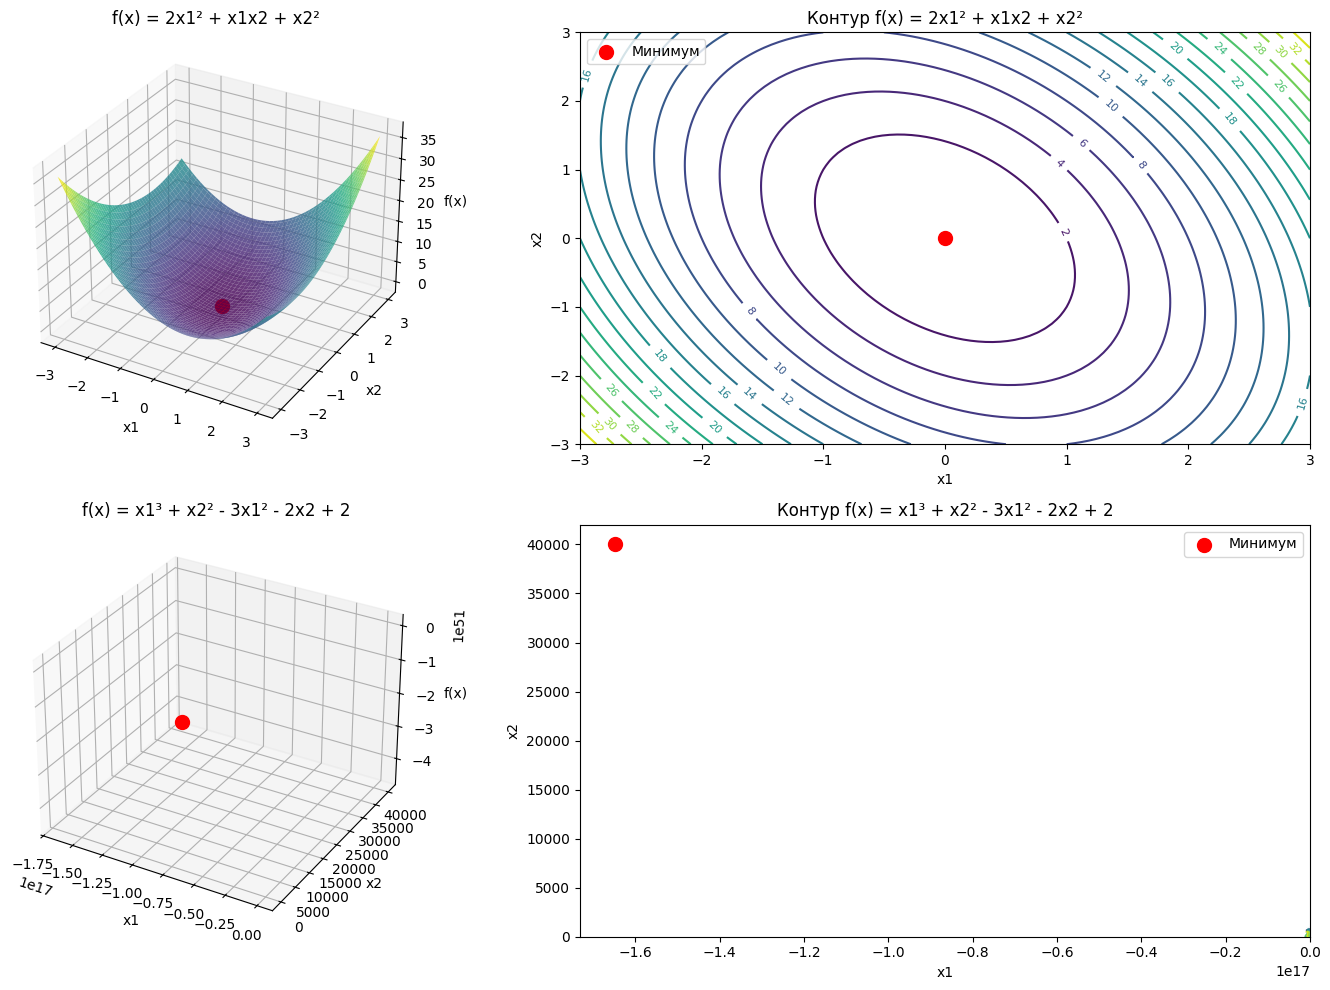


Построение графиков...


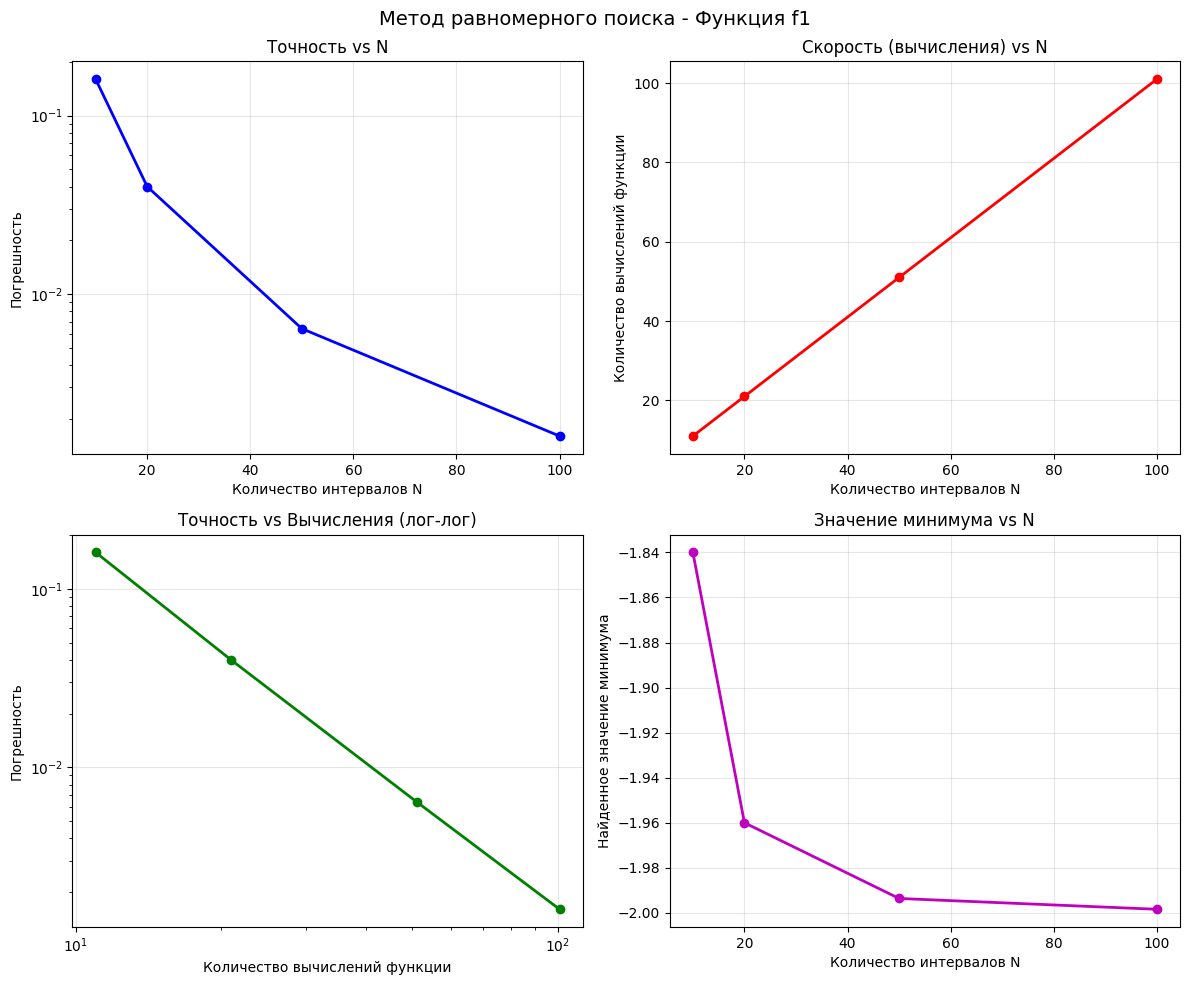

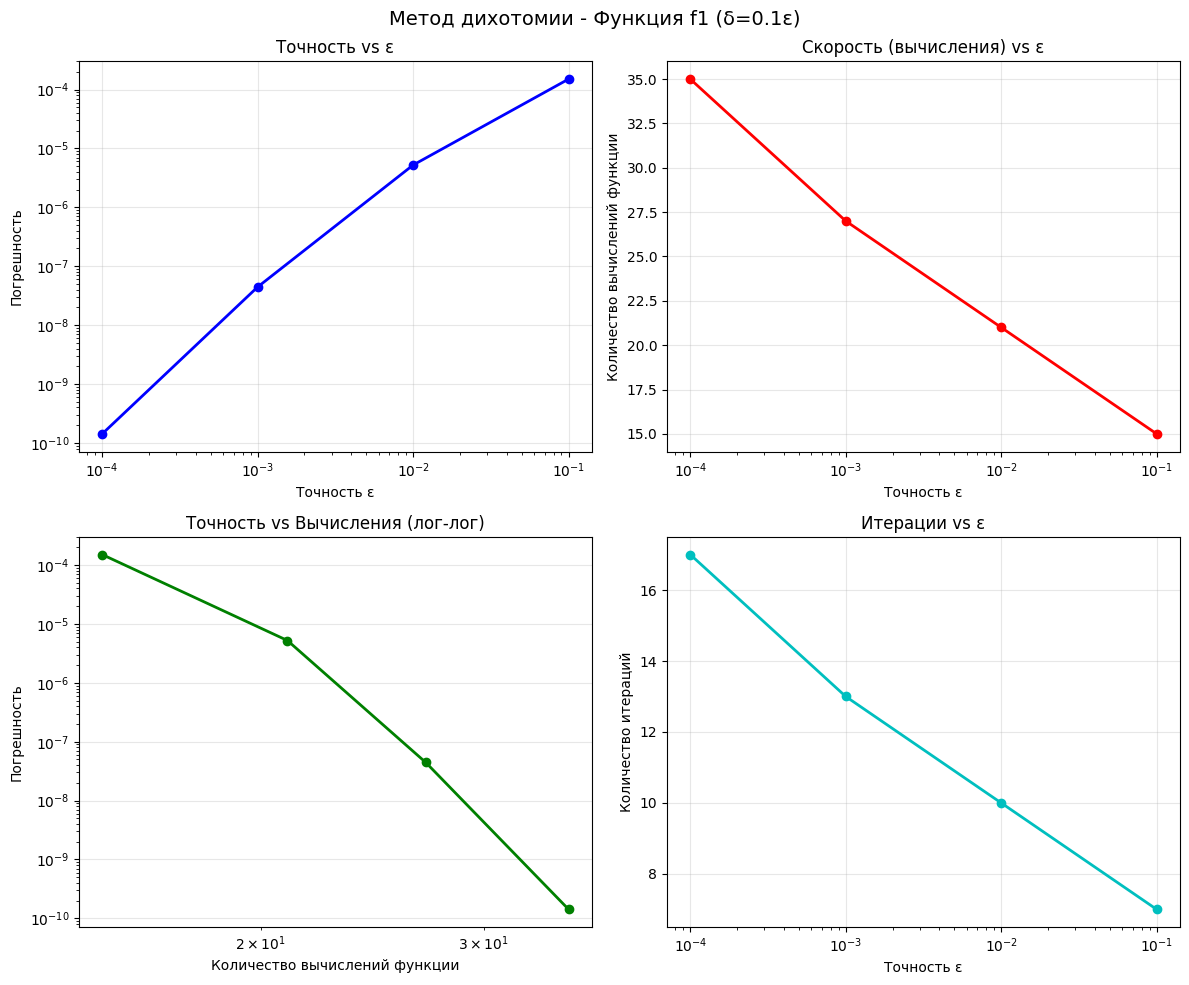

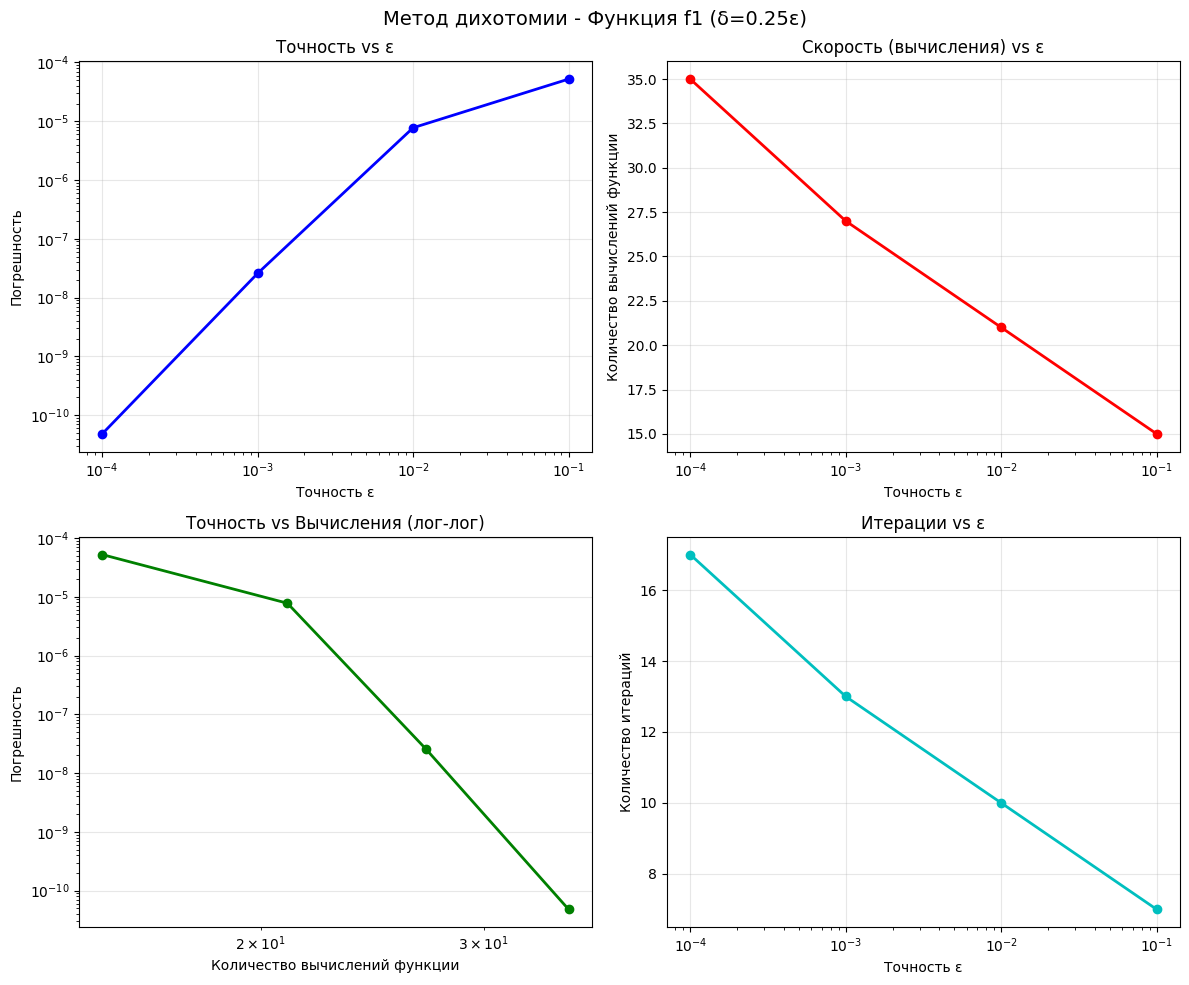

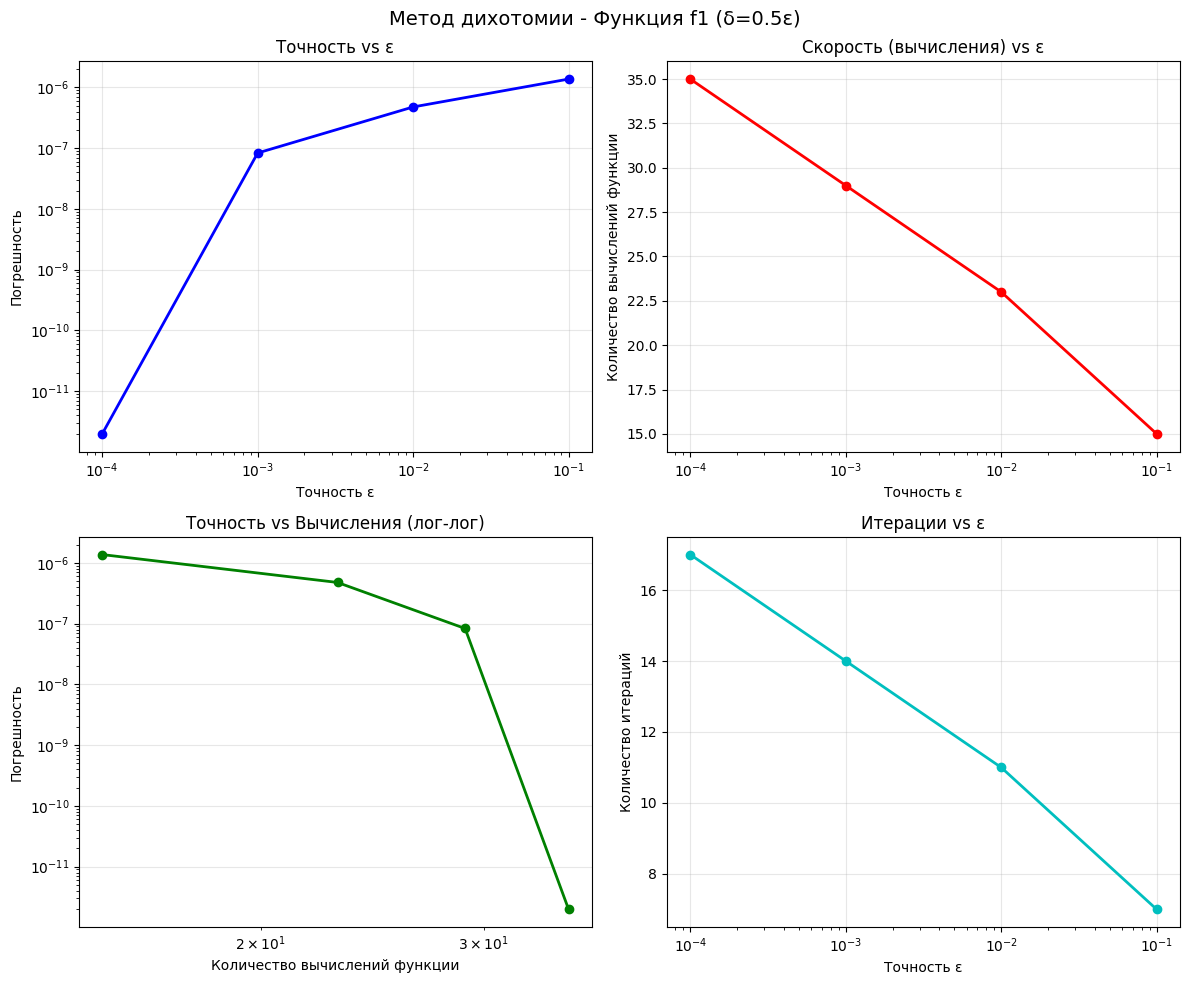

/tmp/ipykernel_124549/1883037243.py:684: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


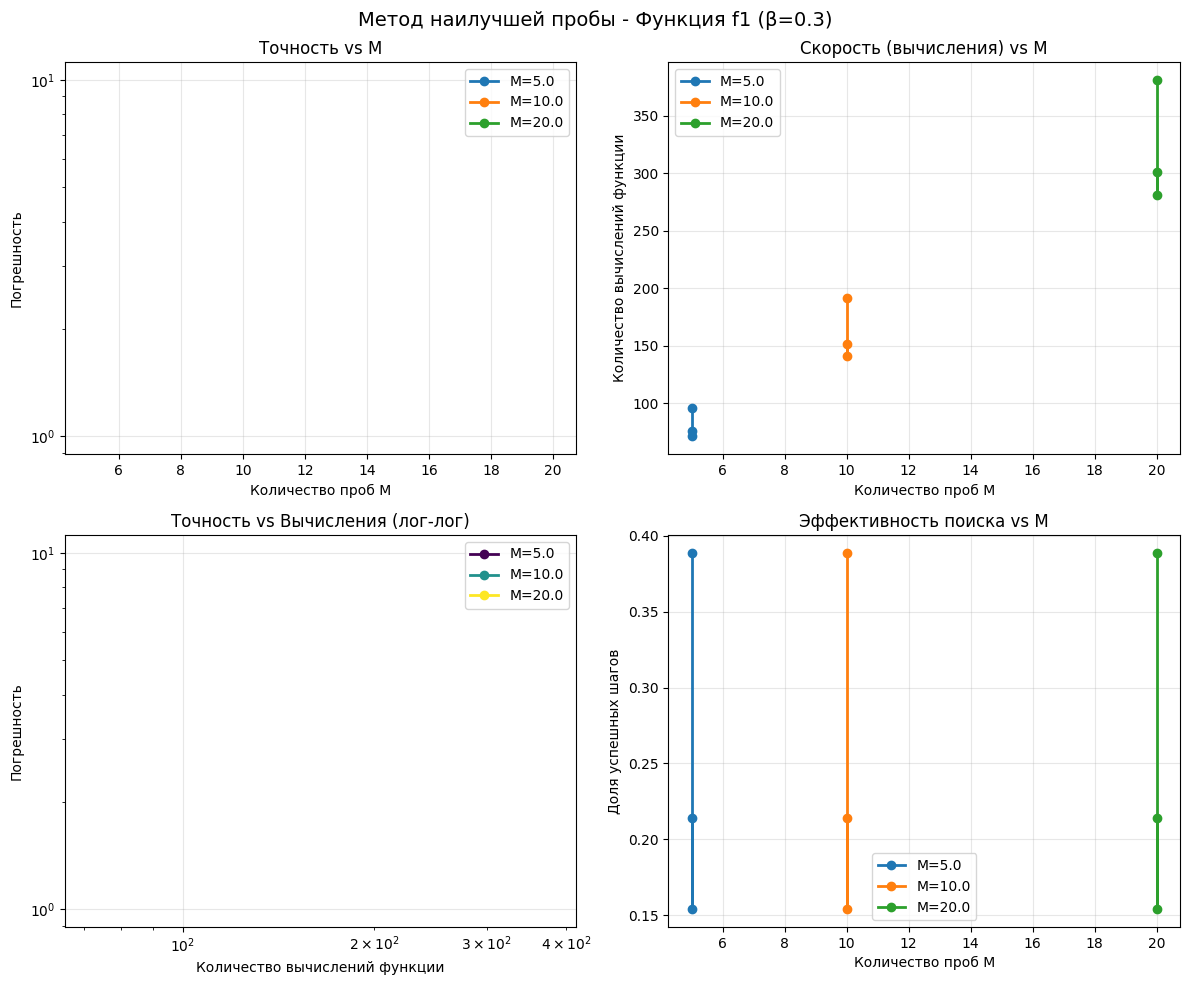

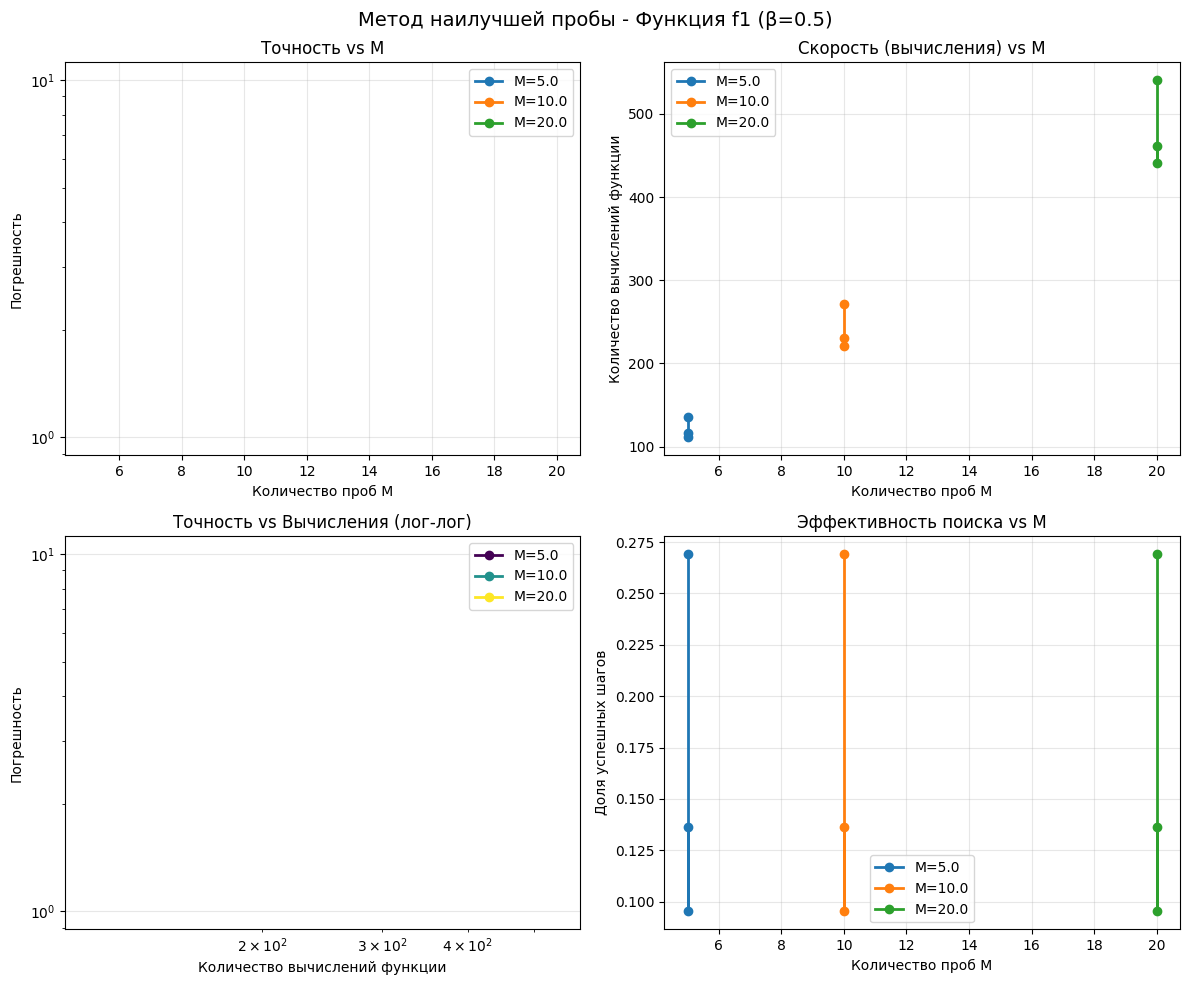

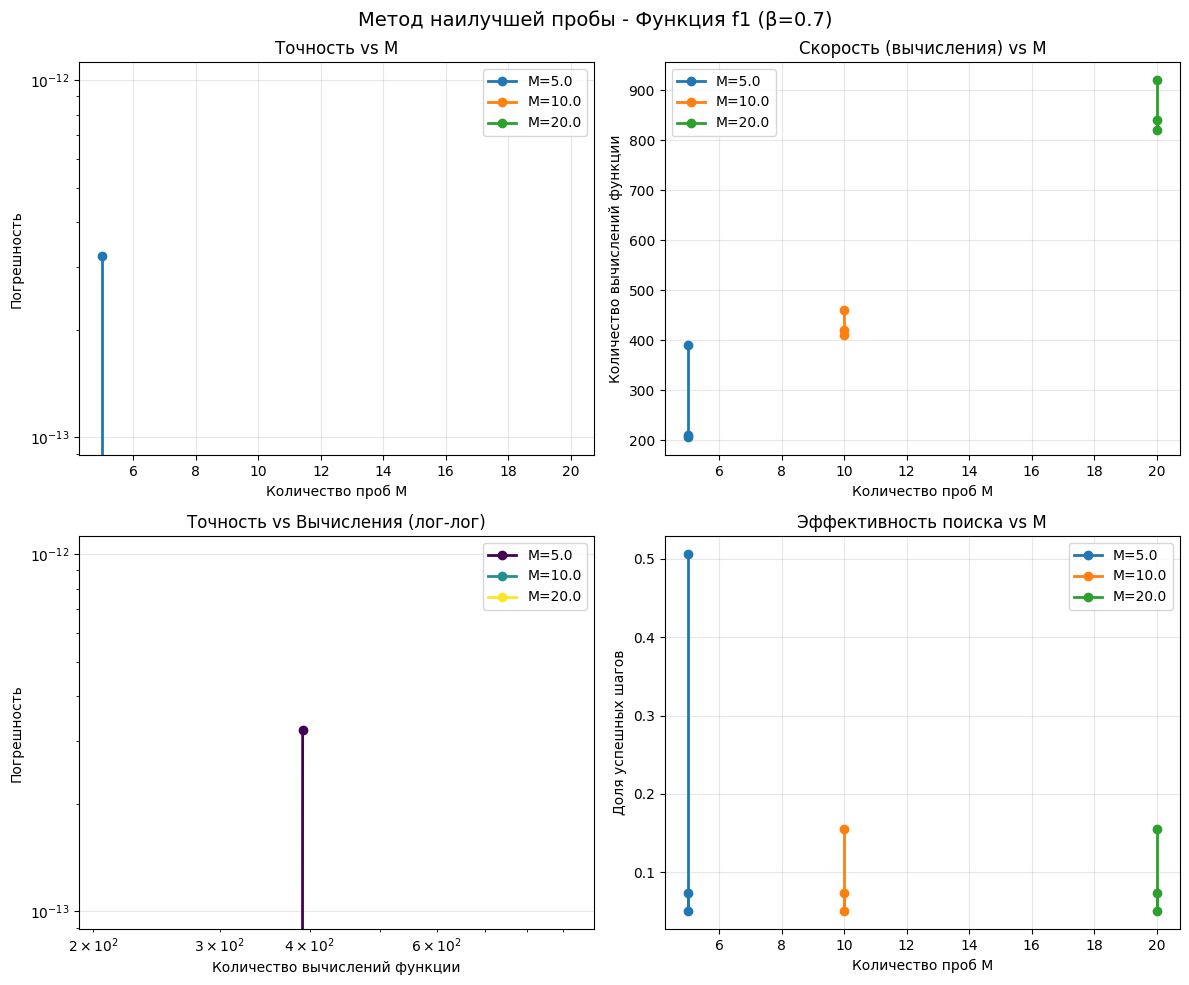

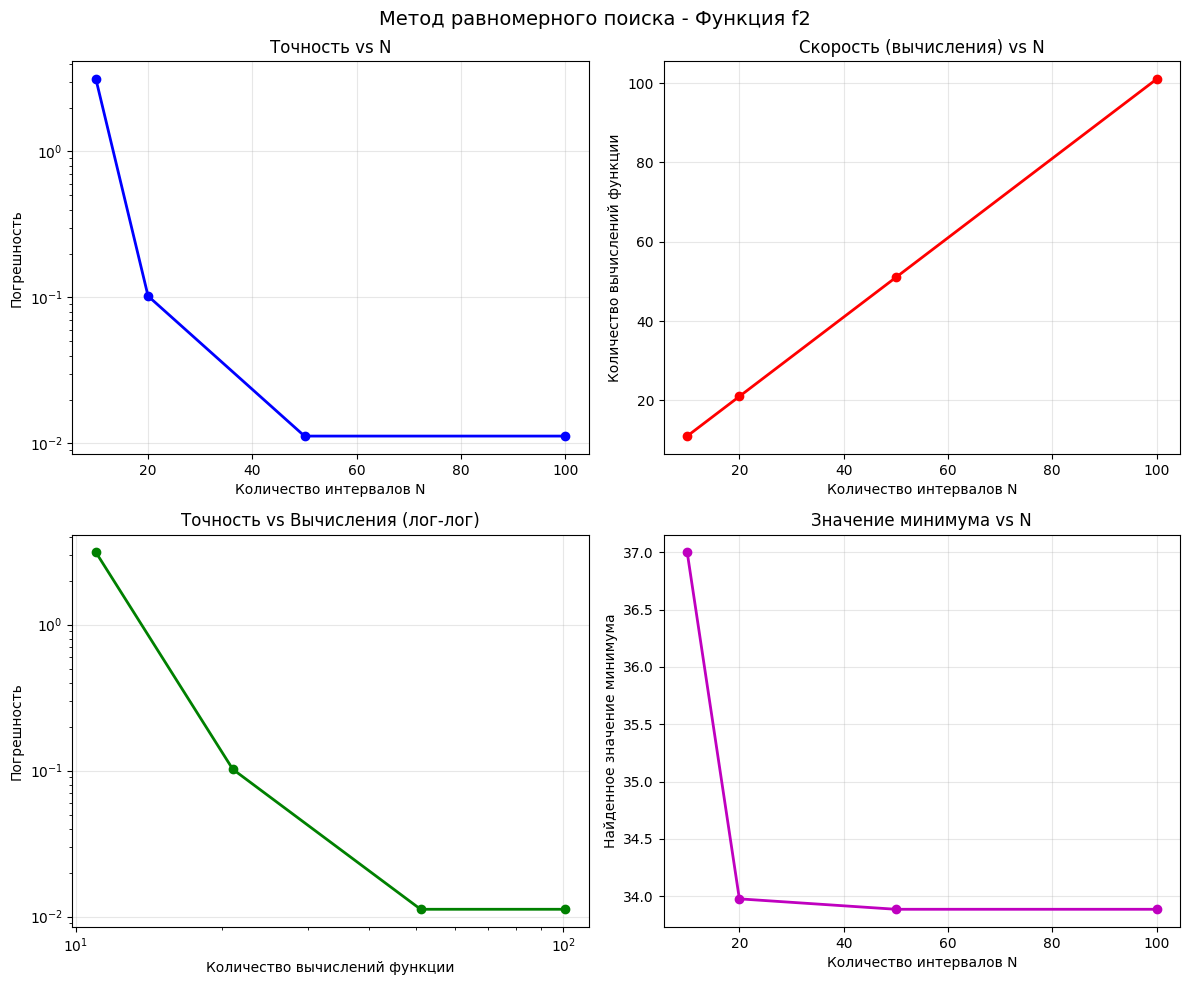

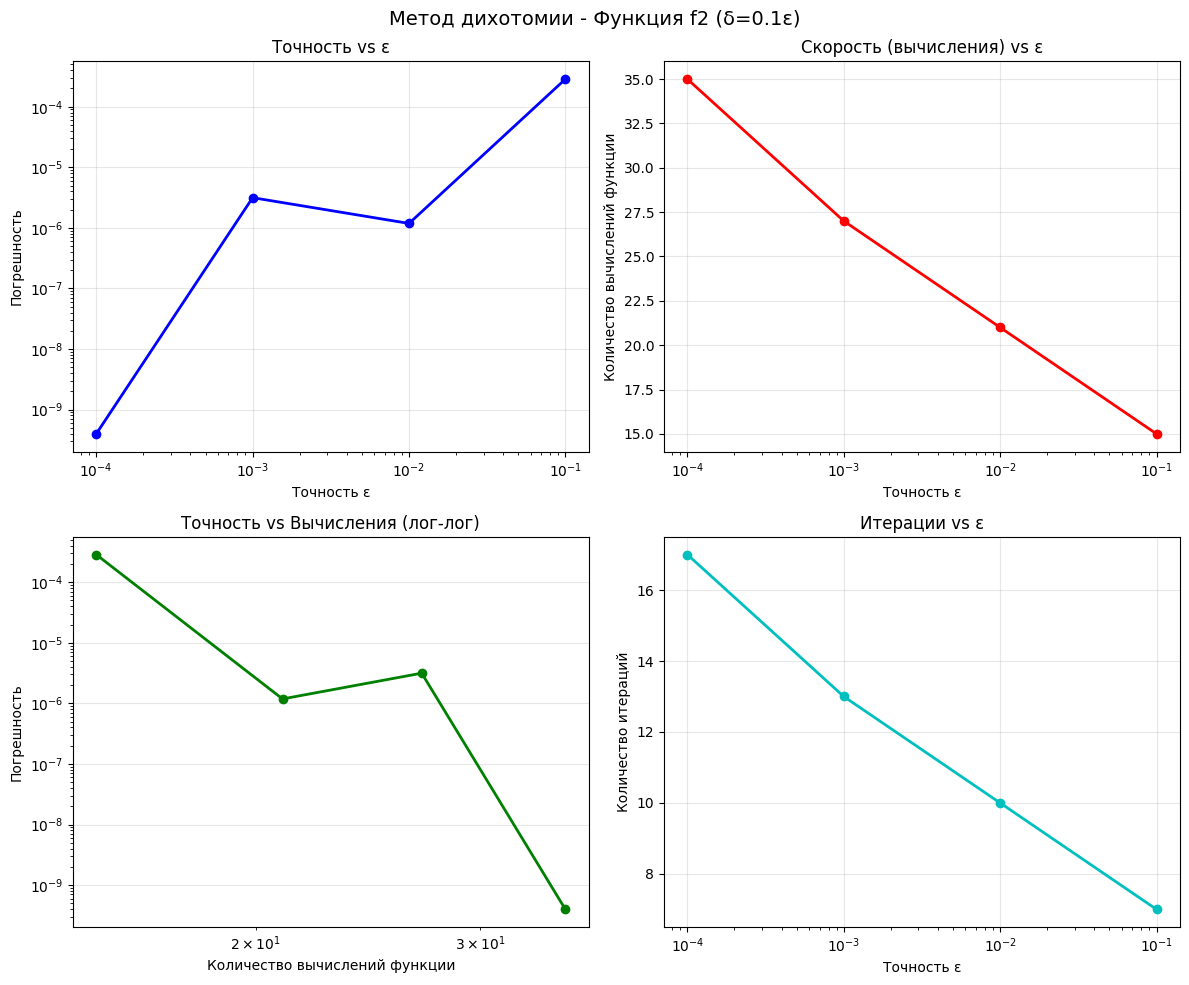

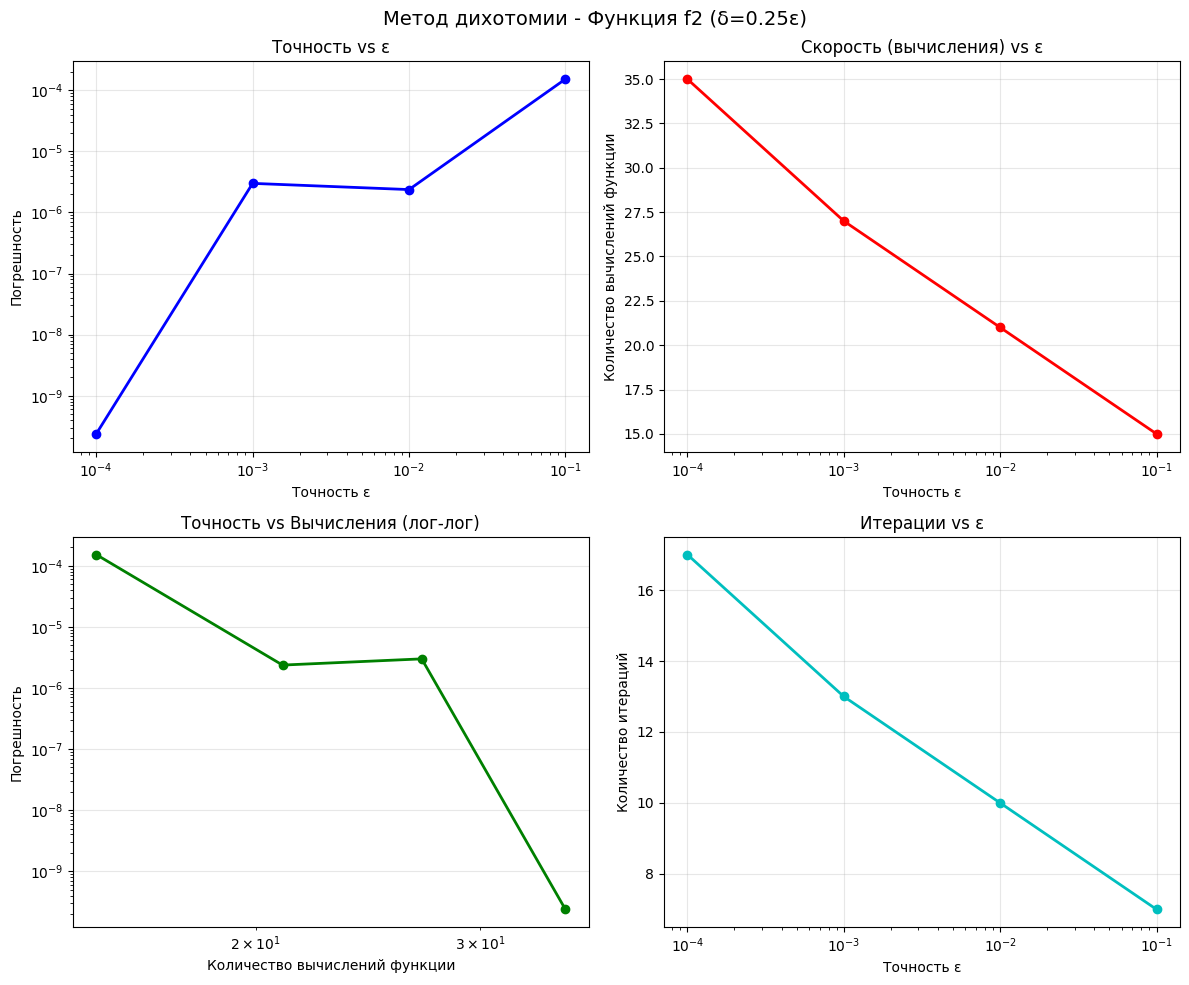

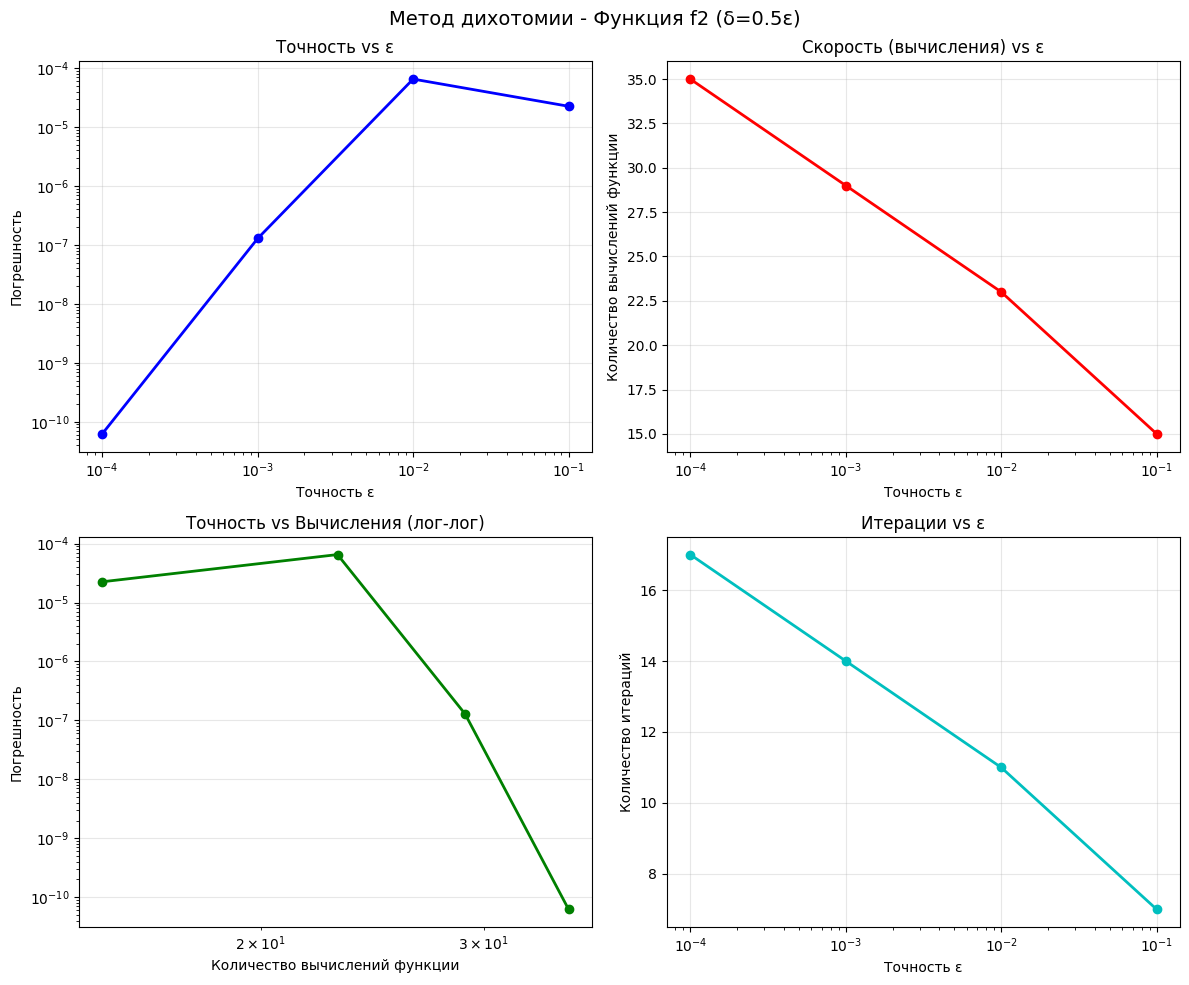

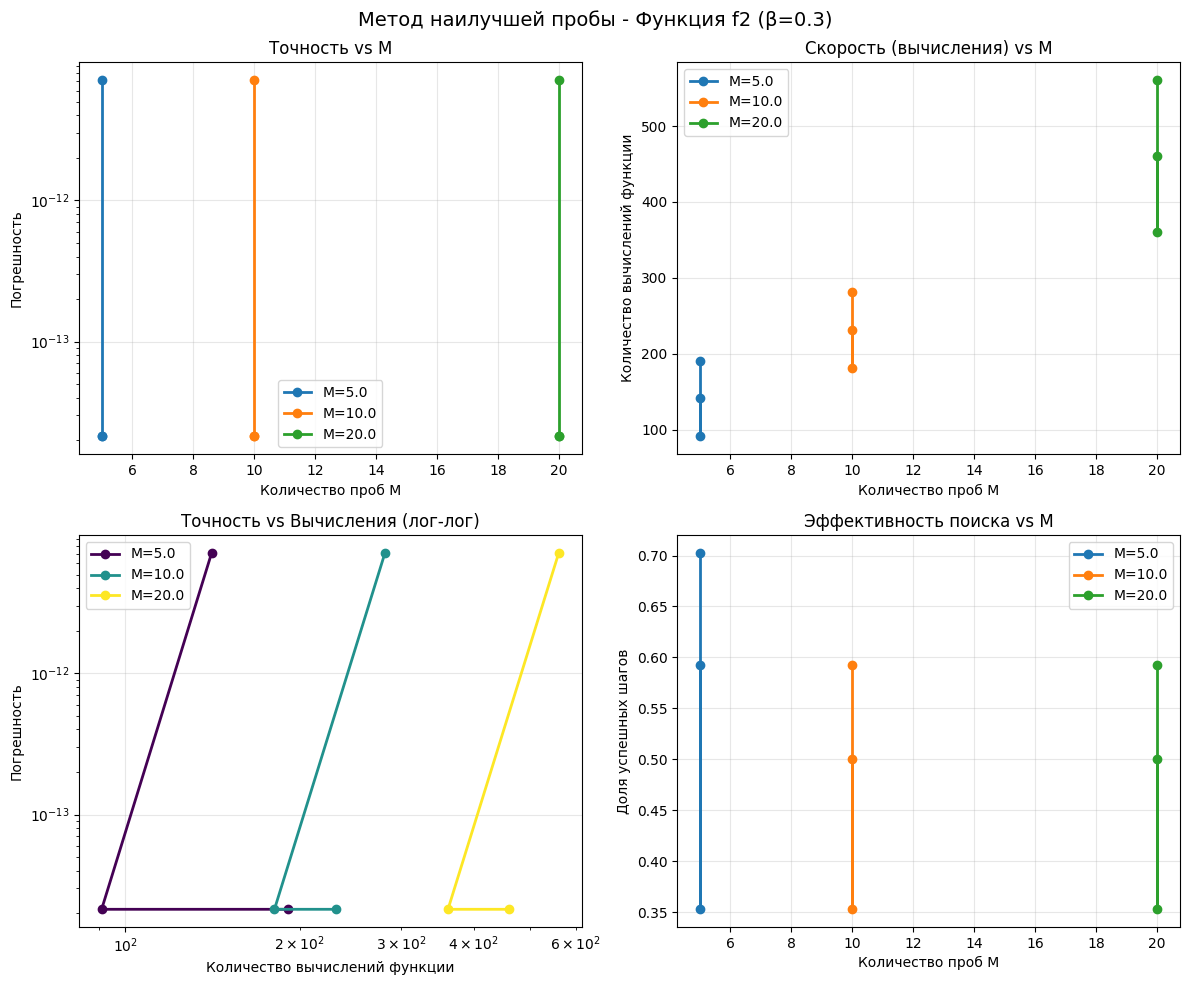

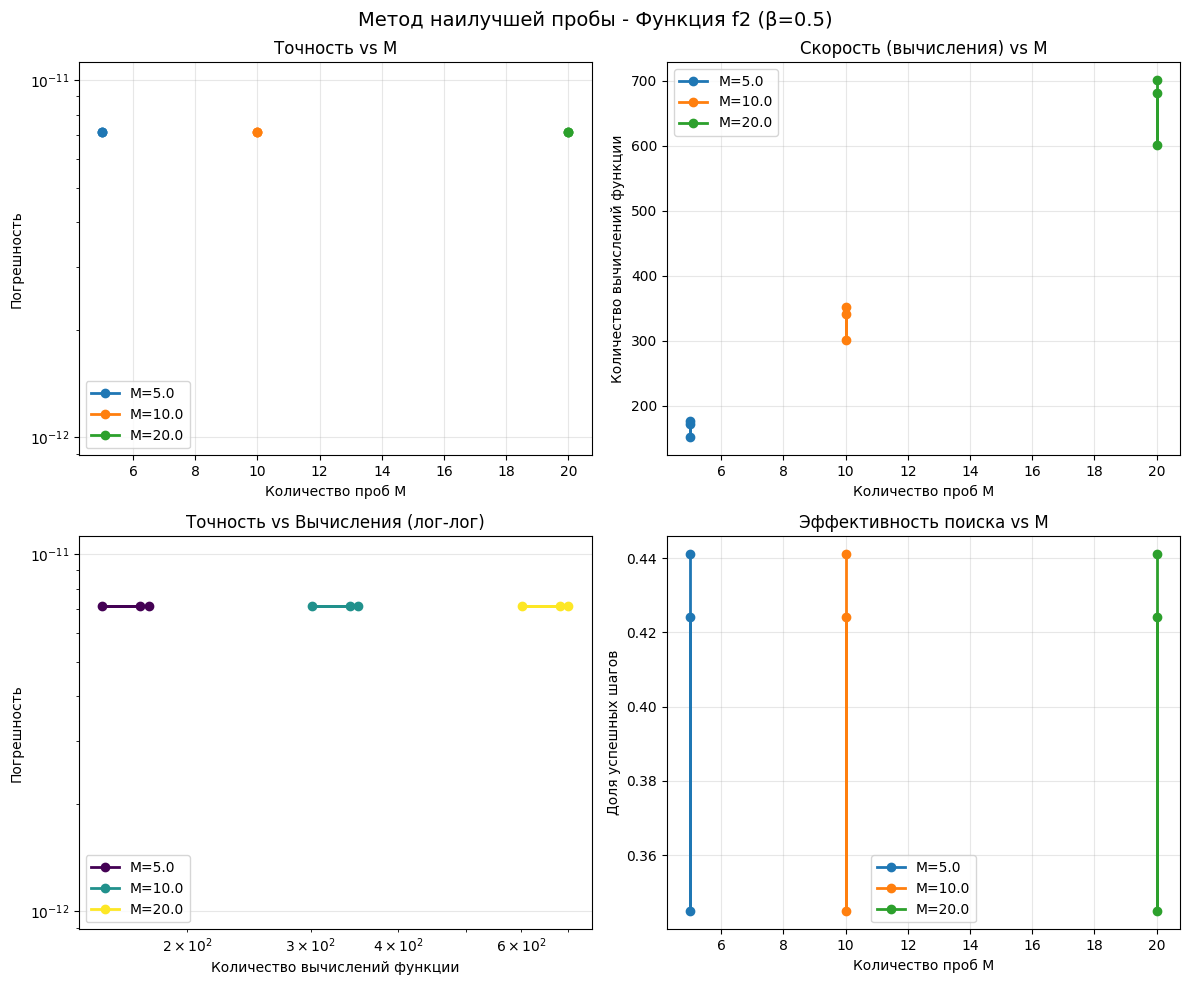

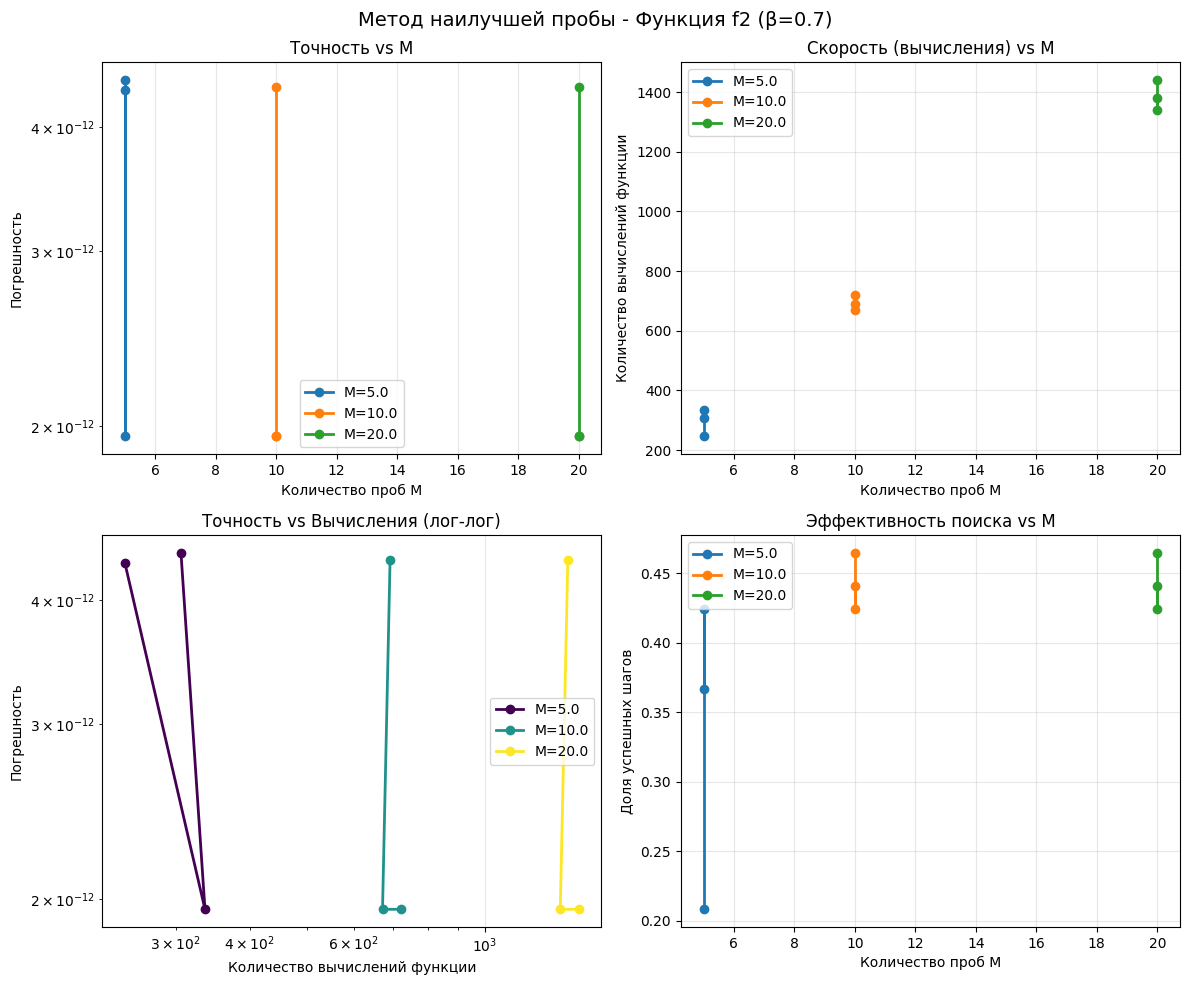

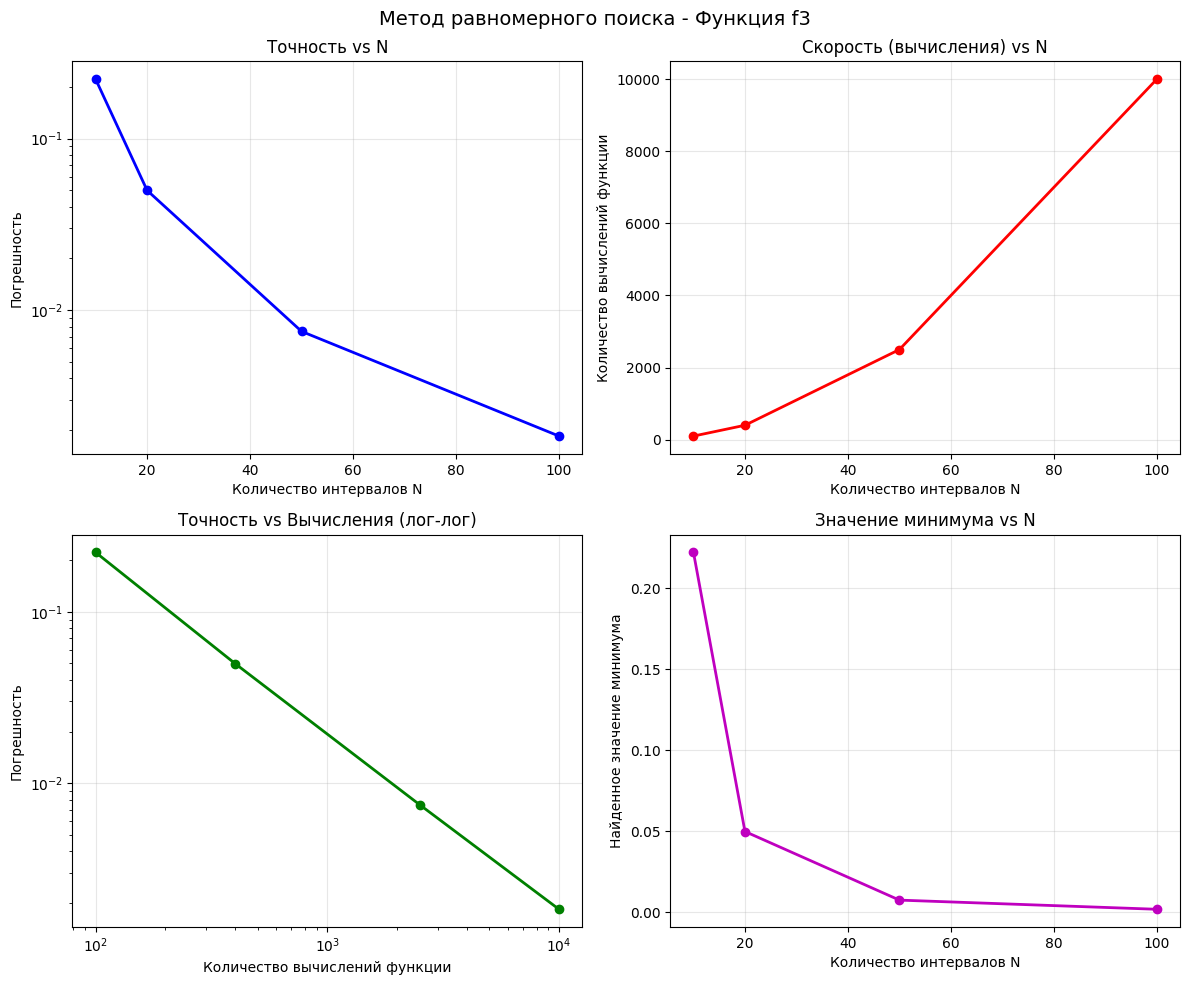

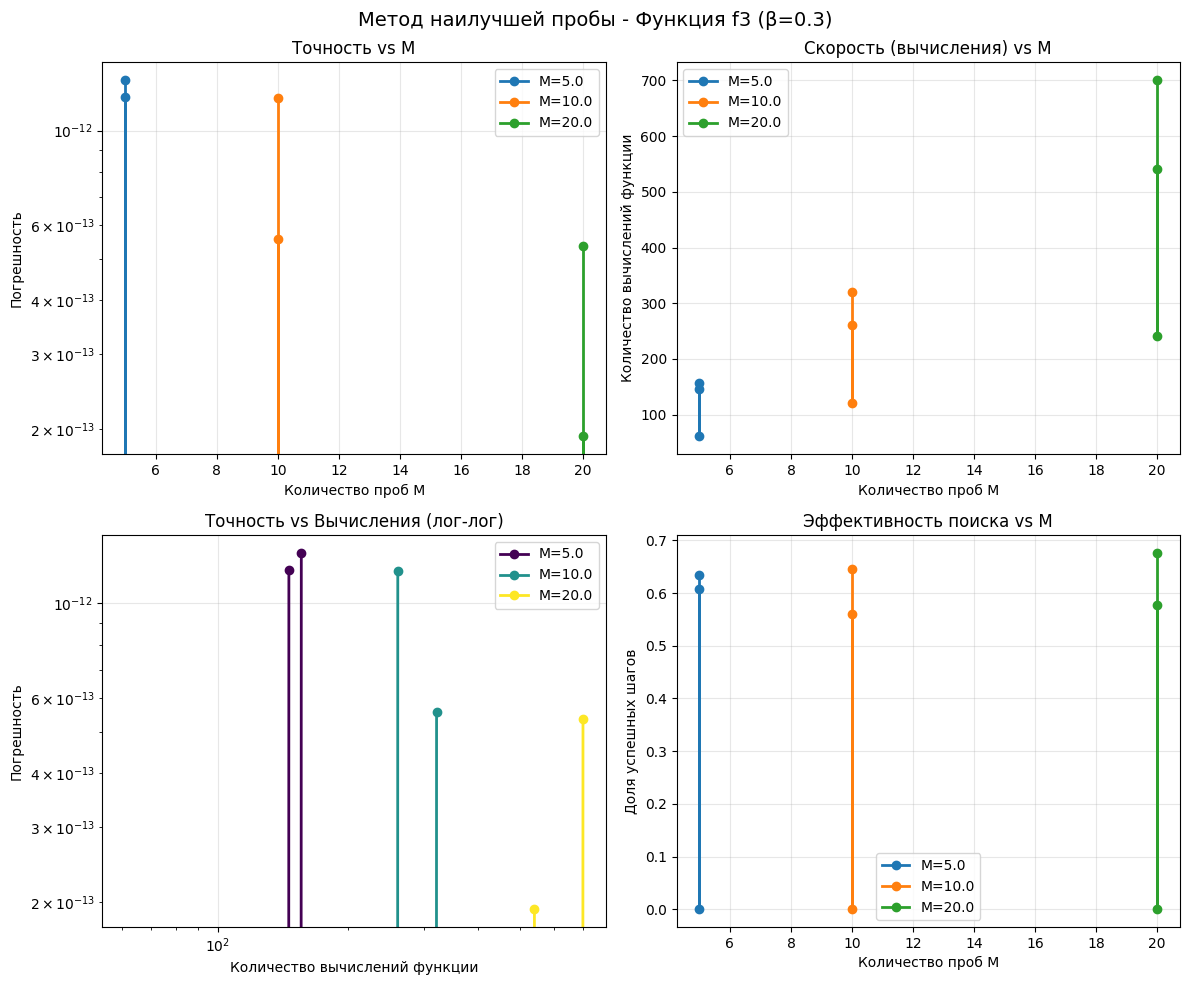

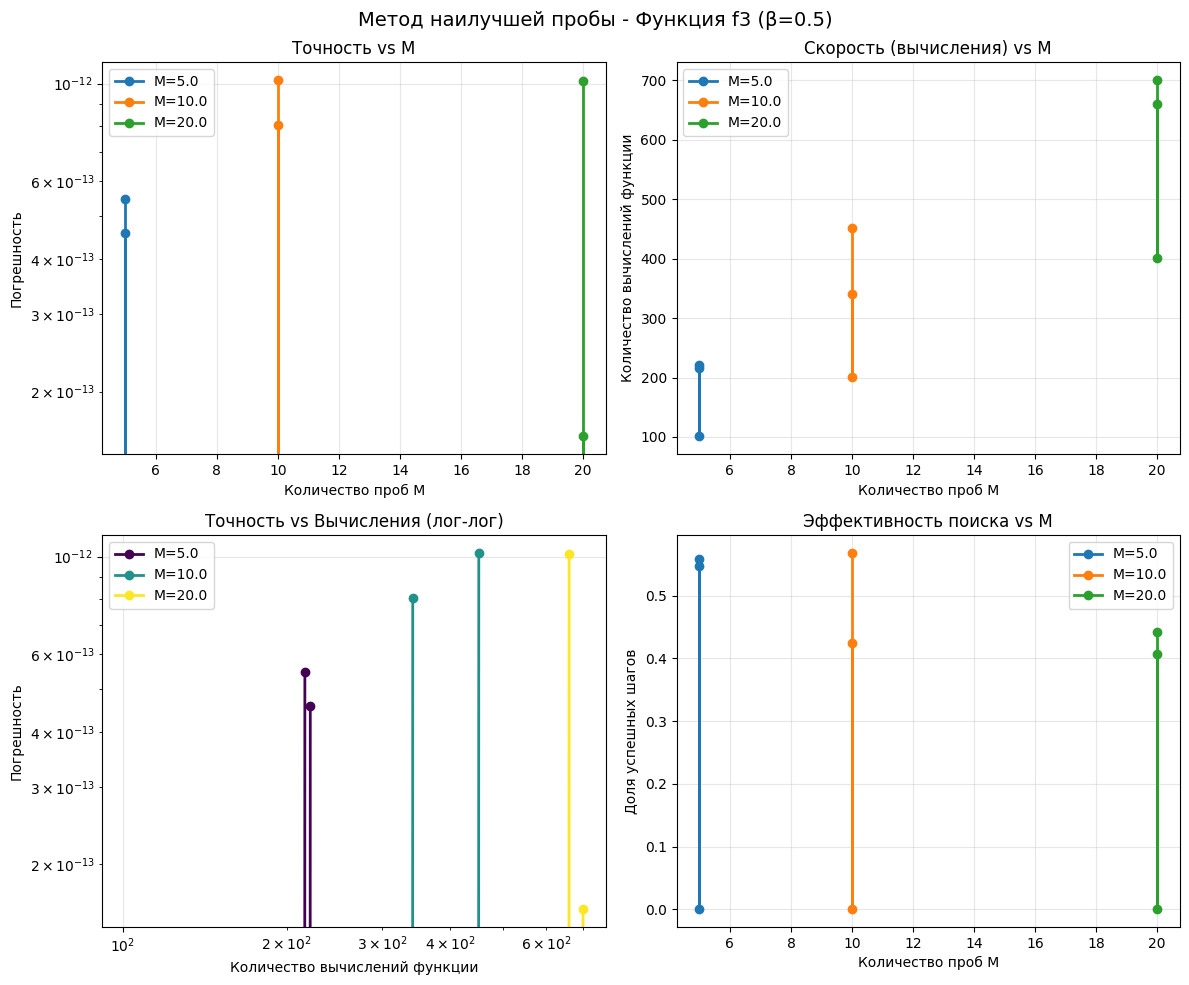

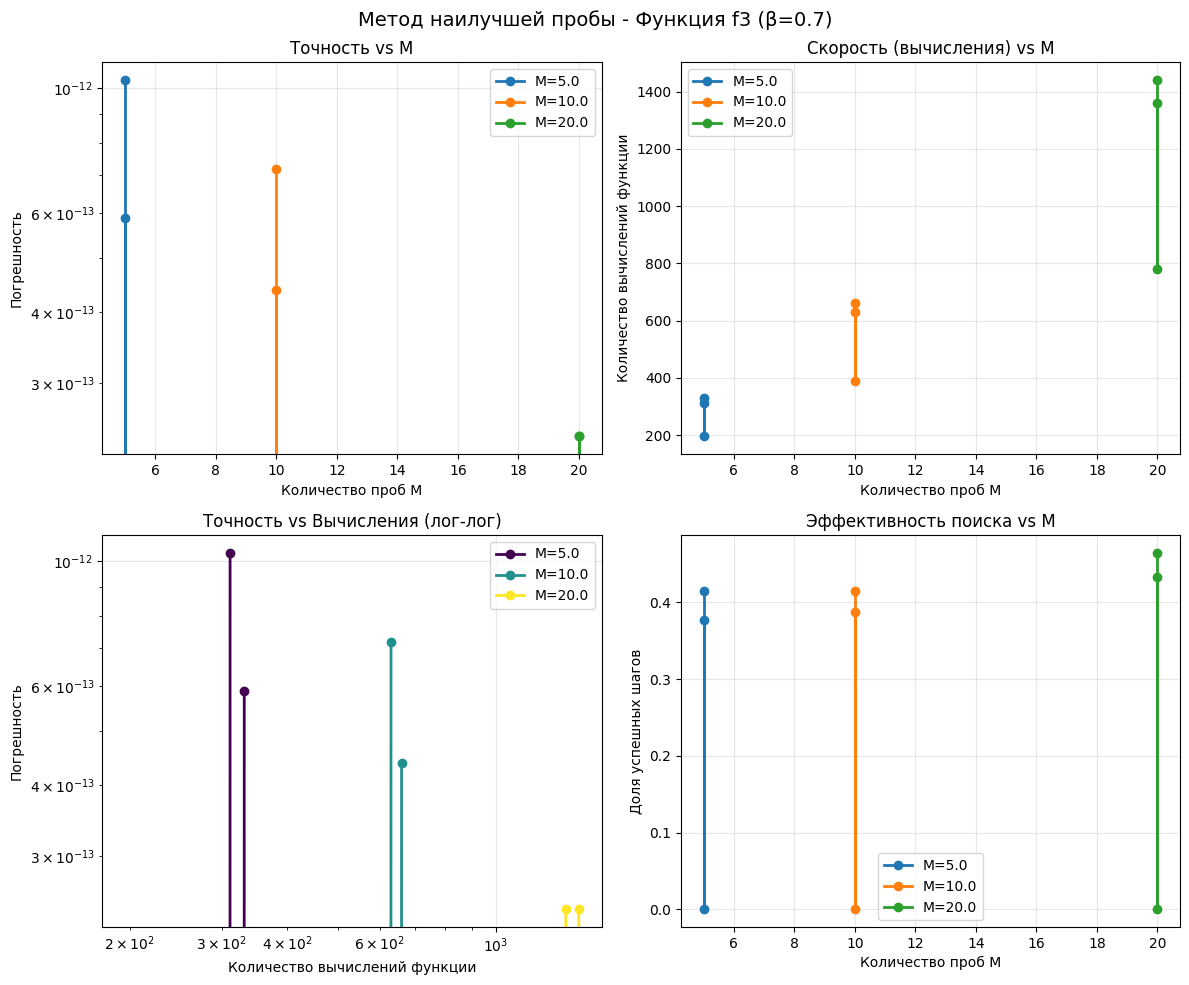

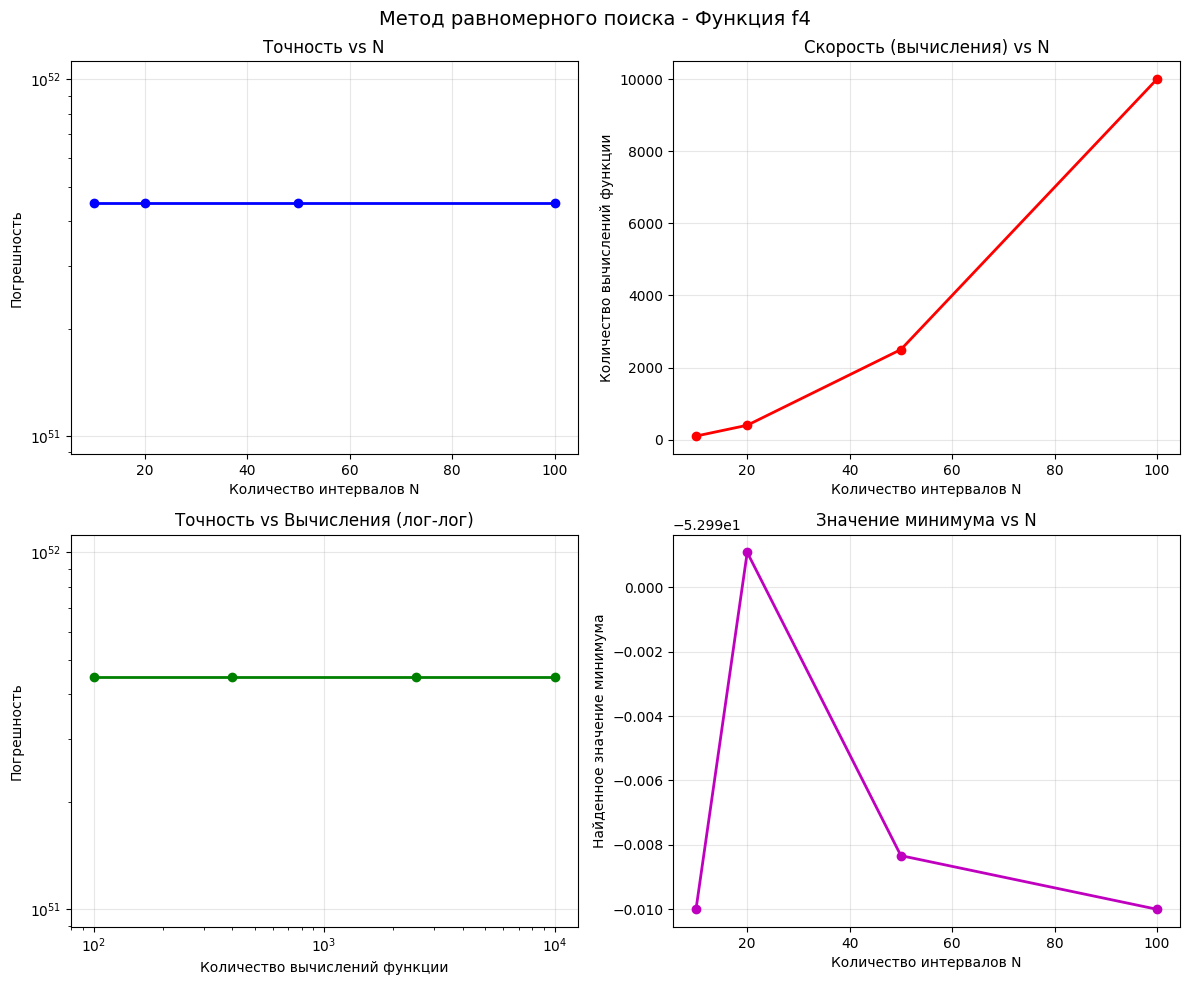

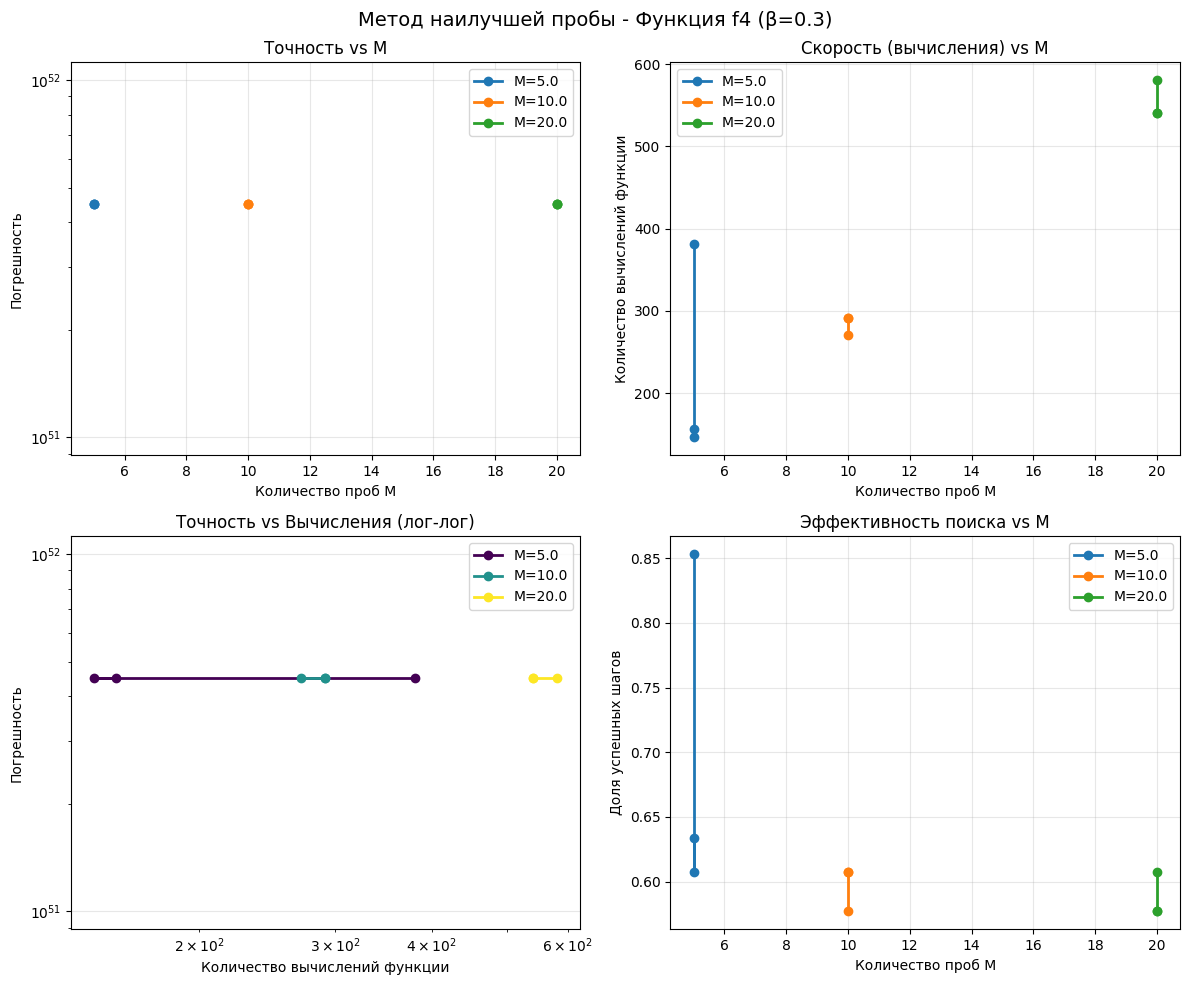

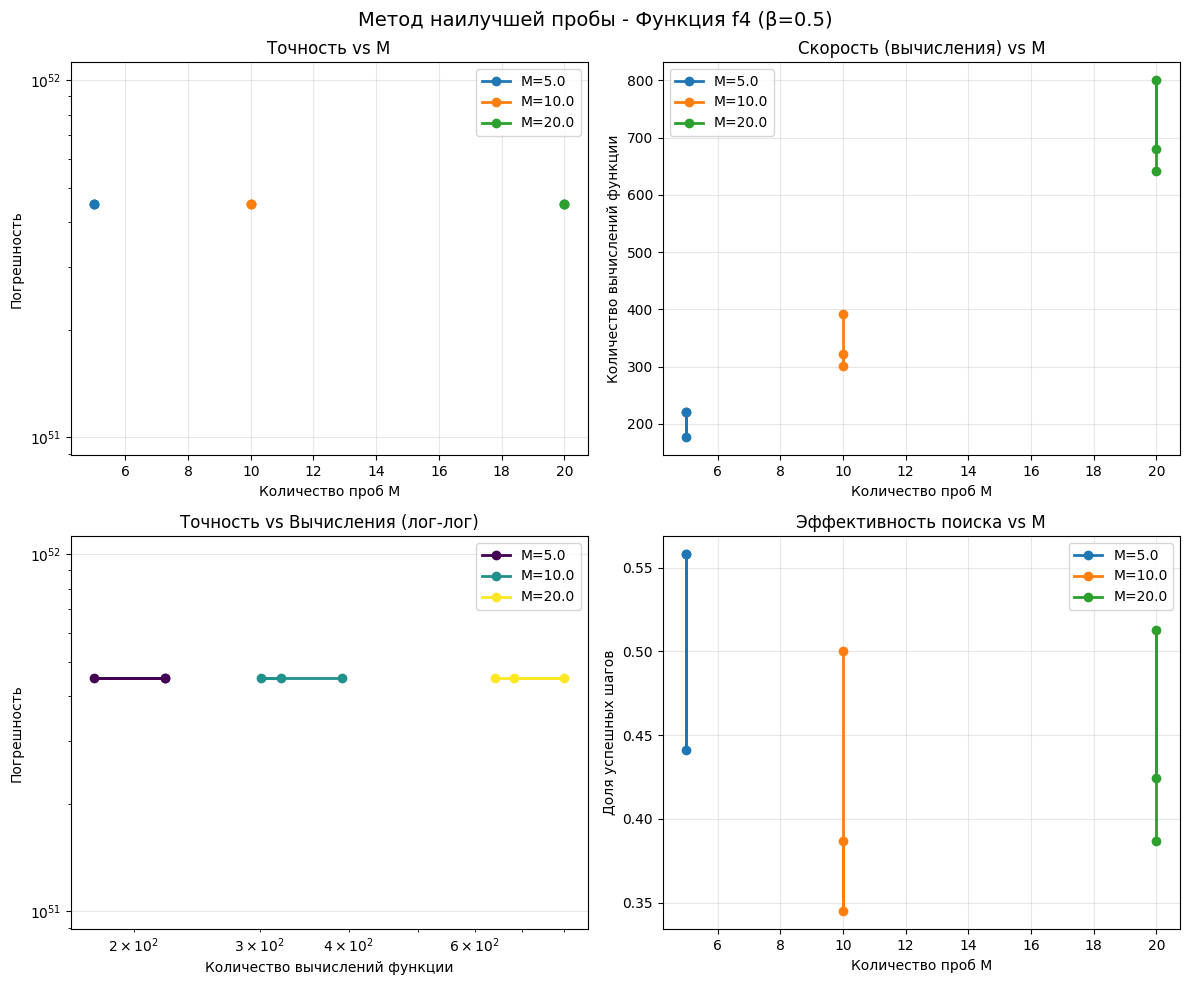

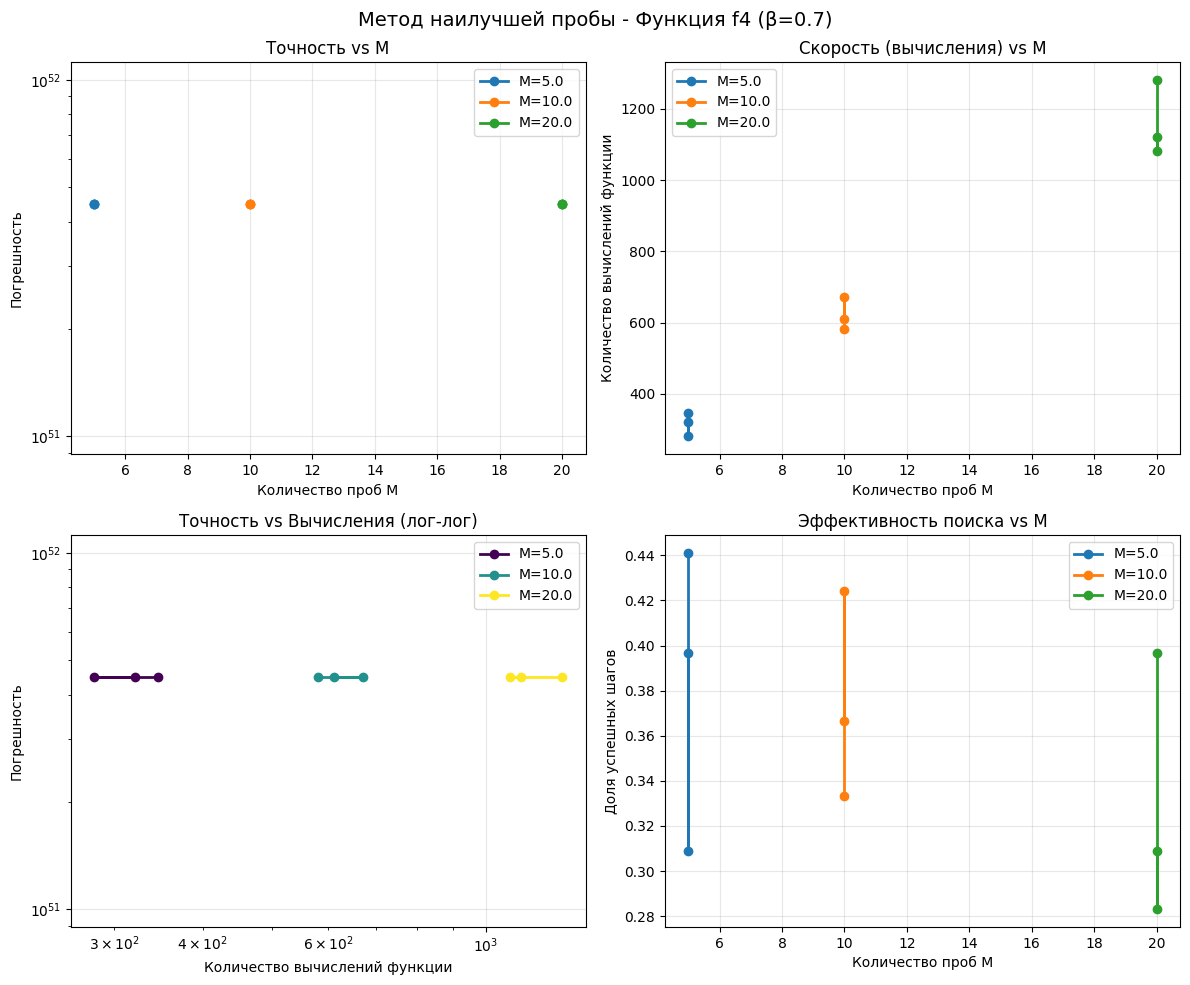

/tmp/ipykernel_124549/1883037243.py:728: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(error_data, labels=labels)


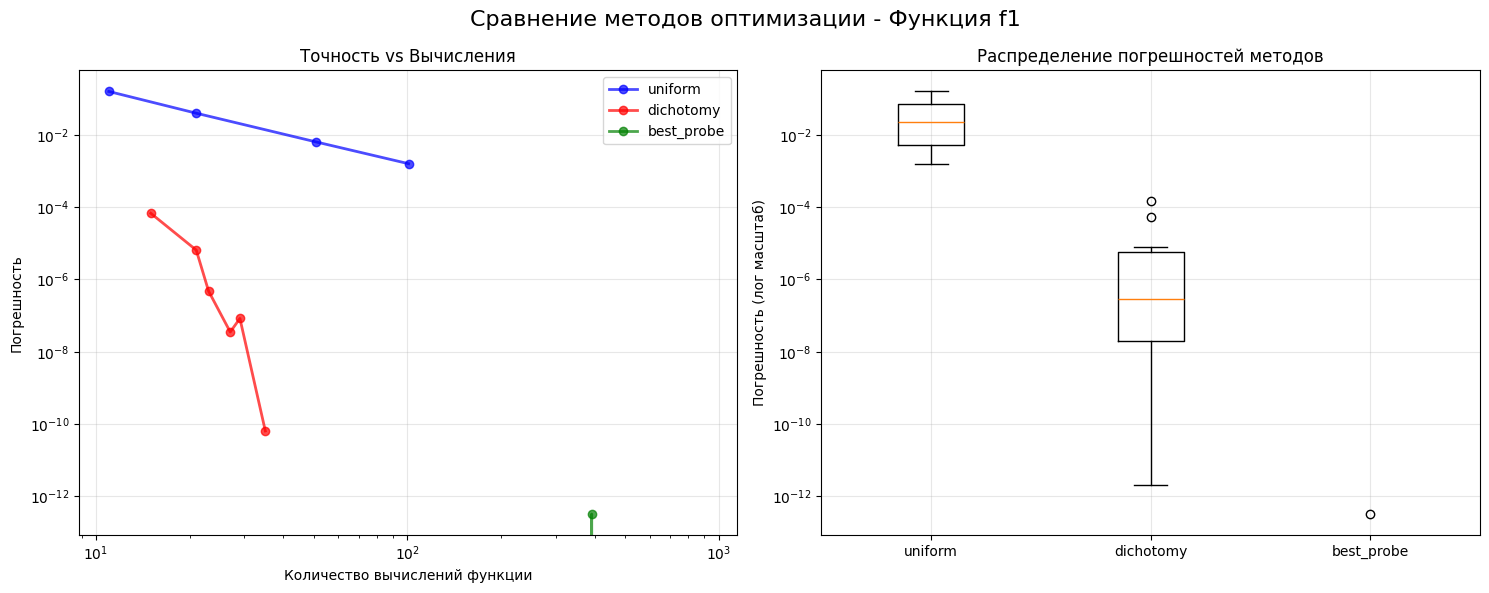

/tmp/ipykernel_124549/1883037243.py:728: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(error_data, labels=labels)


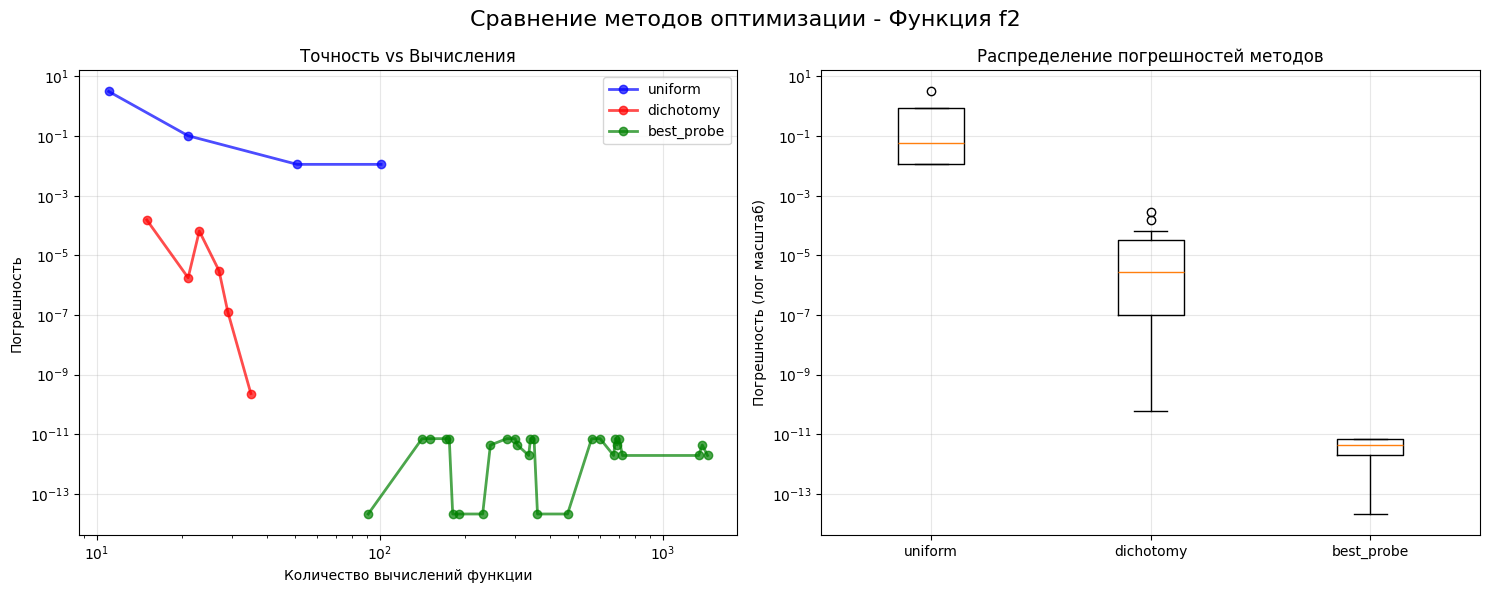

/tmp/ipykernel_124549/1883037243.py:728: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(error_data, labels=labels)


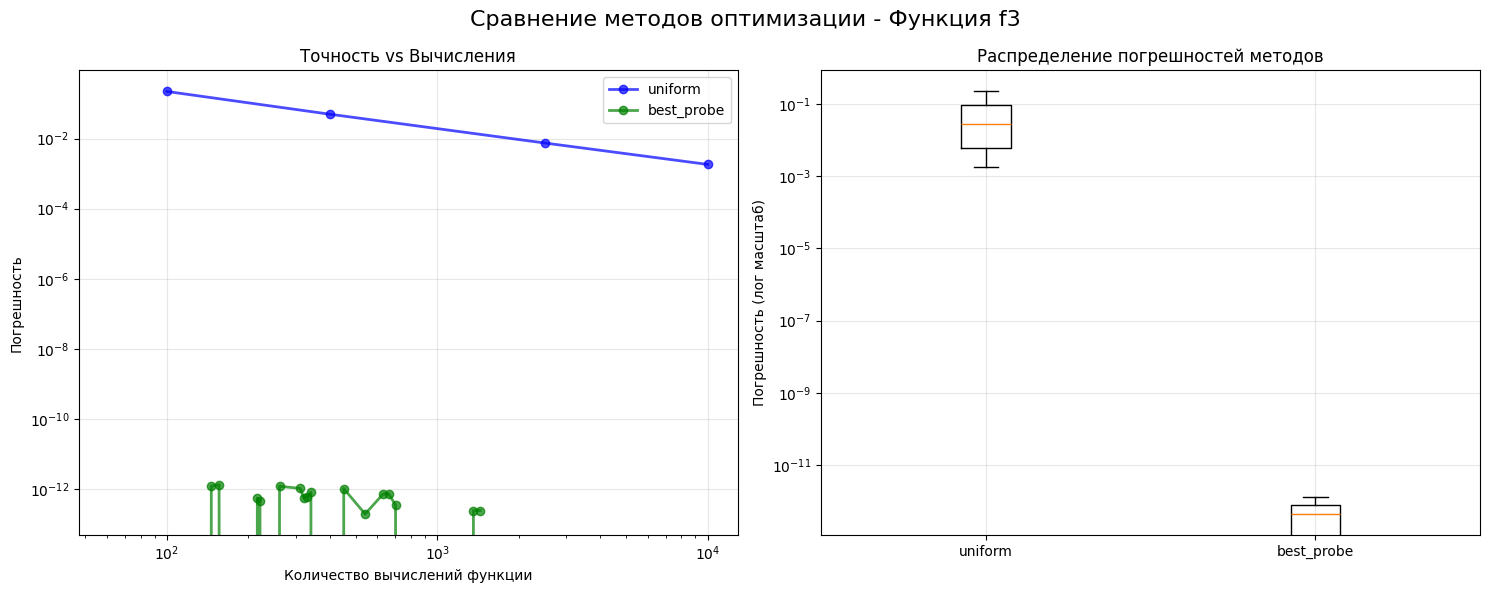

/tmp/ipykernel_124549/1883037243.py:728: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(error_data, labels=labels)


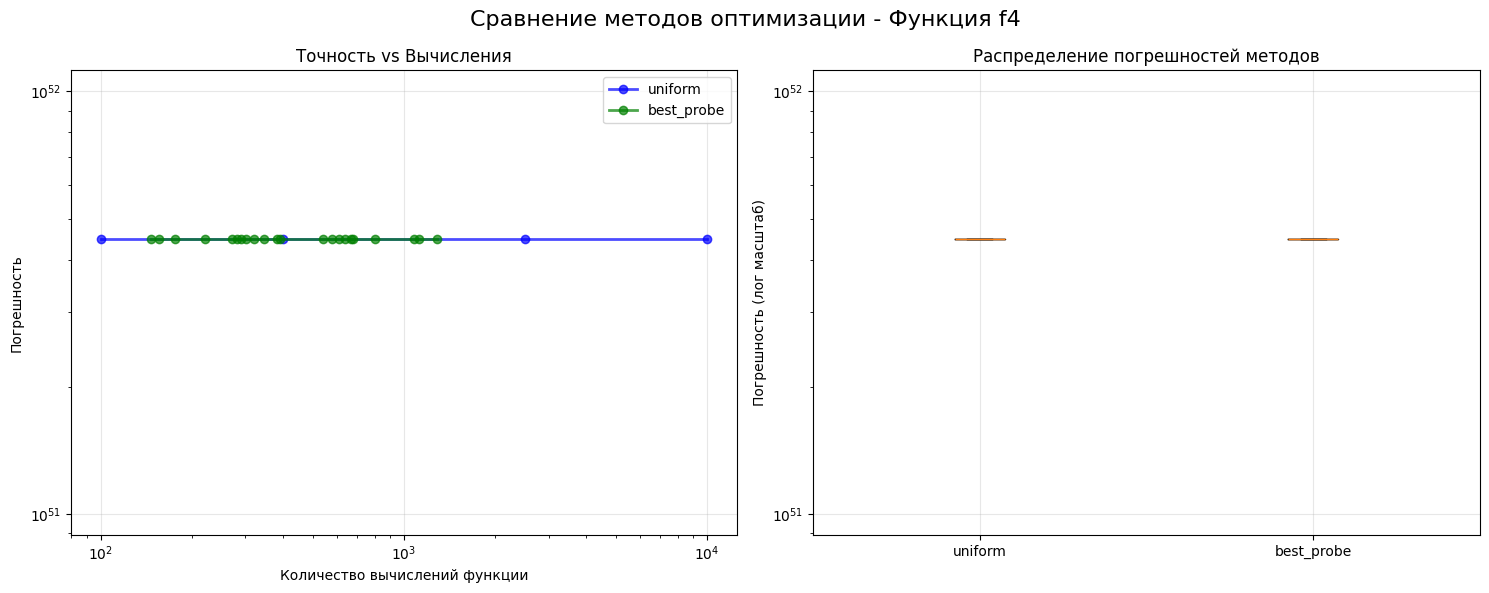

In [21]:
# Построение графиков
experiment.plot_2d_functions()
print("\nПостроение графиков...")
experiment.plot_results(results_df)